# Big Data Infrastructure - Real estate in Vienna

_Real estate in Vienna_ aims to correlate, visualize and predict real estate prices based on the relationship between various
factors such as unemployment rate, disposable income and population growth in Austria.

Data Sources used for this endeavour - All datapoints are given for each district of Vienna
- [Unemployment Rates (Source: data.gv.at)](https://www.data.gv.at/katalog/dataset/CFE2FF7E9AD53C1EE053C630070AB105)
- [Net Income Vienna (Source: wien.gv.at)](https://www.wien.gv.at/statistik/bezirke/)
- [Population Growth (Source: wien.gv.at)](https://www.wien.gv.at/statistik/bevoelkerung/bevoelkerungsstand/index.html)
- [Real Estate Prices Vienna (Source: data.gv.at)](https://www.data.gv.at/katalog/dataset/kaufpreissammlung-liegenschaften-wien/resource/7b9bdd2d-2ff0-4e6e-bba5-21483d8cf55b)

Planned execution steps:
- Data aggregation and collection (see Planned Data Sources)
- Data preperation and import into MongoDB
- Analysis of data via Jupyter Notebook and MapReduce
- Presentation and visualization of results


## Install pymongo
To be able to execute all given steps it is mandatory to install python packages.

In [17]:
!pip install pymongo
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install mrjob
!pip install scipy

## Connect to DB via connection string
Our database will be a mongoDB, as for our use case it is the best choice as we have different datasets that we want to bring together.

In [18]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings('ignore')

# Provide the mongodb atlas url to connect python to mongodb using pymongo
CONNECTION_STRING = "mongodb://127.0.0.1:27017"

# Create a connection using MongoClient
myclient = MongoClient(CONNECTION_STRING)

print("Connection Successful")

# Check DB 
for db in myclient.list_databases():
    print(db)

Connection Successful
{'name': 'admin', 'sizeOnDisk': 40960, 'empty': False}
{'name': 'config', 'sizeOnDisk': 73728, 'empty': False}
{'name': 'local', 'sizeOnDisk': 40960, 'empty': False}


## Importing the data
We have to import all data files into a proper dataframe, this is for easy insertion into the DB later.

For this step we use the Pandas read_csv function, for more info on the exact data format consult the Data Sources section.
As mentioned above we have 4 datasets: Unemployment rates from 2002, Population Growth in Vienna from 2002, Real Estate Purchases in Vienna from 1990, Net Income in Vienna from 2002.

### Unemployment Data CSV from 2002
We import the CSV as it is, no adjustment needed.


In [19]:
unemploy_df = pd.read_csv('emp-bez-alp.csv', sep = ";", decimal=',', thousands =".")
unemploy_df

NUTS1 NUTS2  NUTS3  DISTRICT_CODE  SUB_DISTRICT_CODE  REF_DATE  REF_YEAR  \
0     AT1  AT13  AT130          90000              90000  20020101      2002   
1     AT1  AT13  AT130          90100              90100  20020101      2002   
2     AT1  AT13  AT130          90200              90200  20020101      2002   
3     AT1  AT13  AT130          90300              90300  20020101      2002   
4     AT1  AT13  AT130          90400              90400  20020101      2002   
..    ...   ...    ...            ...                ...       ...       ...   
427   AT1  AT13  AT130          91900              91900  20190101      2019   
428   AT1  AT13  AT130          92000              92000  20190101      2019   
429   AT1  AT13  AT130          92100              92100  20190101      2019   
430   AT1  AT13  AT130          92200              92200  20190101      2019   
431   AT1  AT13  AT130          92300              92300  20190101      2019   

     ALP_TOT_VALUE  ALP_MAL_VALUE  ALP_FEM_VALUE  ALP_TOT_DENSITY  \
0            74894          44966          29928             68.5   
1              433            232            201             35.4   
2             4784           2933           1851             77.7   
3             3957           2403           1554             68.7   
4             1140            668            472             56.6   
..             ...            ...            ...              ...   
427           3850           2091           1759             82.6   
428           8750           4976           3774            143.9   
429          12823           6943           5880            115.6   
430          11762           6006           5756             90.6   
431           6478           3395           3083             94.7   

     ALP_MAL_DENSITY  ALP_FEM_DENSITY  
0               83.5             54.0  
1               19.0             16.5  
2               47.6             30.1  
3               41.7             27.0  
4               33.1             23.4  
..               ...              ...  
427             44.9             37.8  
428             81.8             62.1  
429             62.6             53.0  
430             46.2             44.3  
431             49.6             45.1  

[432 rows x 13 columns]

### Population Growth Data in Vienna from 2002
We import the CSV as it is, no adjustment needed.

In [20]:
pop_growth_df = pd.read_csv('tab_5.1.2_bevoelkerungsstandund-veraenderung_.csv', sep = ";", decimal='.', encoding='utf-8')
pop_growth_df

Jahr     Wien  1. Innere Stadt  2. Leopoldstadt  3. Landstrasse  \
0   2002  1571123            17630            89016           82227   
1   2003  1592846            17541            89954           82297   
2   2004  1610410            17384            90837           83019   
3   2005  1632569            17294            91364           83827   
4   2006  1652449            17285            92170           84208   
5   2007  1661246            17147            93313           83919   
6   2008  1671221            16976            93463           83050   
7   2009  1680135            16623            93822           82979   
8   2010  1689995            16525            94735           83061   
9   2011  1702855            16385            95302           83955   
10  2012  1717084            16290            96582           84574   
11  2013  1741246            16268            96866           85508   
12  2014  1766746            16131            99597           86454   
13  2015  1797337            16339           101702           88125   
14  2016  1840226            16411           103225           89806   
15  2017  1867582            16465           105003           90183   
16  2018  1888776            16450           105574           90712   
17  2019  1897491            16306           104946           91745   
18  2020  1911191            16047           105848           91680   

    4. Wieden  5. Margareten  6. Mariahilf  7. Neubau  8. Josefstadt  ...  \
0       28975          49785         28525      28912          22219  ...   
1       29348          50367         28805      28968          23156  ...   
2       29394          51098         28891      29012          23309  ...   
3       29573          51882         29012      29161          23588  ...   
4       30126          52534         29369      30416          23597  ...   
5       30189          52286         29463      29955          23613  ...   
6       30262          52434         29430      30054          23703  ...   
7       30348          52288         29197      29878          23639  ...   
8       30331          52354         29323      30069          23435  ...   
9       30541          52753         29308      30062          23379  ...   
10      30724          52581         29388      30101          23560  ...   
11      30989          53071         30117      30309          23930  ...   
12      31452          53610         30613      30792          24279  ...   
13      31691          54246         31000      31291          24518  ...   
14      32751          54938         31620      32020          25054  ...   
15      33035          55356         31865      32197          25528  ...   
16      33319          55640         32069      32467          25662  ...   
17      33263          55407         31864      32288          25466  ...   
18      33212          55123         31651      31961          25021  ...   

    14. Penzing  15. Rudolfsheim-Fuenfhaus  16. Ottakring  17. Hernals  \
0         79142                      67482          87914        48827   
1         80185                      67976          89153        49428   
2         80505                      68760          89822        50278   
3         81785                      69467          91997        51316   
4         82829                      70235          93817        52480   
5         83246                      70228          93877        52626   
6         83751                      70291          94193        52414   
7         83980                      70600          94526        52253   
8         84090                      70830          94816        52328   
9         84566                      71491          94951        52293   
10        84973                      71651          95704        52647   
11        86248                      73527          97565        53489   
12        87597                      74791          99094        54422   
13    

### Real Estate Purchase list from 1990 (Kaufpreissammlung Liegenschaften Wien)
We import the CSV as it is, no adjustment needed.

In [21]:
real_estate_vienna_df = pd.read_csv('kaufpreissammlung-liegenschaften.csv', sep = ";", decimal=',', encoding='latin-1', low_memory=False)
real_estate_vienna_df

KG.Code    Katastralgemeinde      EZ     PLZ                   Straße  \
0         1617         Strebersdorf  1417.0  1210.0                  Mühlweg   
1         1607  Groß Jedlersdorf II   193.0  1210.0            Bahnsteggasse   
2         1209         Ober St.Veit  3570.0  1130.0              Jennerplatz   
3         1207                Lainz   405.0  1130.0  Sebastian-Brunner-Gasse   
4         1101            Favoriten  3831.0  1100.0       Laxenburger Straße   
...        ...                  ...     ...     ...                      ...   
57907     1204           Hadersdorf  1057.0  1140.0         Laskywiesengasse   
57908     1204           Hadersdorf  1200.0  1140.0       Robert-Fuchs-Gasse   
57909     1206           Hütteldorf  2760.0  1140.0              Ulmenstraße   
57910     1216           Weidlingau     5.0  1140.0              Hauptstraße   
57911     1206           Hütteldorf   816.0  1140.0         Steinböckengasse   

            ON     Gst.  Gst.Fl.          ErwArt Erwerbsdatum  ...  \
0           13   752/16    755.0     Kaufvertrag   13.10.2021  ...   
1            4      408    510.0     Kaufvertrag   13.09.2021  ...   
2        34/20    938/3    456.0     Kaufvertrag   10.08.2021  ...   
3            6     8/23    523.0     Kaufvertrag   30.12.2020  ...   
4      2C -2 D  2044/19  12768.0     Kaufvertrag   04.11.2020  ...   
...        ...      ...      ...             ...          ...  ...   
57907       10      889   1313.0     Kaufvertrag   18.08.2021  ...   
57908    25-31      448   4003.0     Kaufvertrag   05.12.2018  ...   
57909       48   1232/1    499.0     Kaufvertrag   15.06.2021  ...   
57910      114     11/2   1649.0     Kaufvertrag   26.07.2021  ...   
57911       57    685/1     21.0  MA 64-Bescheid   01.12.2021  ...   

      Baureifgest % Widmung Baurecht  Bis auf EZ Stammeinlage  \
0          FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
1          FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
2          FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
3          FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
4          FALSCH      30.0   FALSCH  NaN    NaN       FALSCH   
...           ...       ...      ...  ...    ...          ...   
57907      FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
57908      FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
57909      FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
57910      FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   
57911      FALSCH     100.0   FALSCH  NaN    NaN       FALSCH   

               sonst_wid sonst_wid_prz ber. Kaufpreis Bauzins  
0                    NaN           NaN       750000.0     NaN  
1                    NaN           NaN      1250000.0     NaN  
2                    NaN           NaN       480000.0     NaN  
3                    NaN           NaN      1600000.0     NaN  
4      W  V  22 g , Wi g        40 ,30     15000000.0     NaN  
...                  ...           ...            ...     ...  
57907                NaN           NaN       950000.0     NaN  
57908                NaN           NaN      5200000.0     NaN  
57909                NaN           NaN       699000.0     NaN  
57910                NaN           NaN      1496000.0     NaN  
57911                NaN           NaN         9450.0     NaN  

[57912 rows x 47 columns]

### Net Income Data in Vienna from 2002
We import the CSV as it is, no adjustment needed.

In [22]:
net_income_vienna_df = pd.read_csv('vie-bez-biz-ecn-inc-sex-2002f.csv', sep=';', decimal=',')
net_income_vienna_df

NUTS  DISTRICT_CODE  SUB_DISTRICT_CODE  REF_YEAR  REF_DATE INC_TOT_VALUE  \
0    AT13          90000              90000      2002  20021231        18.217   
1    AT13          90100              90100      2002  20021231        25.463   
2    AT13          90200              90200      2002  20021231        16.439   
3    AT13          90300              90300      2002  20021231        18.701   
4    AT13          90400              90400      2002  20021231        20.325   
..    ...            ...                ...       ...       ...           ...   
451  AT13          91900              91900      2020  20201231        29.195   
452  AT13          92000              92000      2020  20201231        20.671   
453  AT13          92100              92100      2020  20201231        24.061   
454  AT13          92200              92200      2020  20201231        26.272   
455  AT13          92300              92300      2020  20201231        26.900   

    INC_MAL_VALUE INC_FEM_VALUE  
0          20.709        15.424  
1          31.961        18.536  
2          18.301        14.282  
3          21.444        15.804  
4          23.641        16.876  
..            ...           ...  
451        34.102        24.257  
452        21.591        19.531  
453        26.202        21.693  
454        29.302        23.100  
455        30.160        23.451  

[456 rows x 8 columns]

### Insert datasets into MongoDB
In the next step, we insert our dataframes into our permanent data store of choice, MongoDB.
MongoDB makes that easy - we just have to insert the dataframes as they are.

In [23]:
# In MongoDB collections and DBs are only created on first insert (reminiscent of Git folders)
db = myclient["immodb"]

# We insert the whole dateframes into the DB

# Insert unemploymentData
db.unemploymentData.insert_many(unemploy_df.to_dict('records'))
# Insert populationGrowth
db.populationGrowth.insert_many(pop_growth_df.to_dict('records'))
# Insert realEstateVienna
db.realEstateVienna.insert_many(real_estate_vienna_df.to_dict('records'))
# Insert netIncomeVienna
db.netIncomeVienna.insert_many(net_income_vienna_df.to_dict('records'))

# Check if colletions have been created
print(db.list_collection_names())

['netIncomeVienna', 'populationGrowth', 'realEstateVienna', 'unemploymentData']


### Have a look into the database
Now for sanity checking, we can output the rowcount of our MongoDB collections!

In [24]:
db = myclient["immodb"]
unemp_col = db["unemploymentData"]
populationGrowth_col = db["populationGrowth"]
realEstateVienna_col = db["realEstateVienna"]
netIncomeVienna_col = db["netIncomeVienna"]

data = [(unemp_col.find(), 'Unemployment Data'), (populationGrowth_col.find(), 'Population Growth'), (realEstateVienna_col.find(), 'Real Estate Sales'), (netIncomeVienna_col.find(), 'Net Income')]
for (cur, title) in data:
    print(title, '\nRow Count: ', len(list(cur)))

Unemployment Data 
Row Count:  432
Population Growth 
Row Count:  19
Real Estate Sales 
Row Count:  57912
Net Income 
Row Count:  456


### Drop database (if needed)
And we can also drop all of our data, i.e. in case something about our sources changes

In [25]:
# Drop all collections
# db["unemploymentData"].drop()
# db["populationGrowth"].drop()
# db["realEstateVienna"].drop()
# db["netIncomeVienna"].drop()

### Load data from database
In this step, we read in all of our data from the MongoDB into Pandas dataframes!
Also again very easy with MongoDB. We add only IDs as an index.

#### Unemployment Data

In [26]:
unemployment_fromDb = pd.DataFrame(list(unemp_col.find()))
unemployment_fromDb = unemployment_fromDb.set_index("_id")
unemployment_fromDb

NUTS1 NUTS2  NUTS3  DISTRICT_CODE  SUB_DISTRICT_CODE  \
_id                                                                             
626936081a9fc54e64120d73   AT1  AT13  AT130          90000              90000   
626936081a9fc54e64120d74   AT1  AT13  AT130          90100              90100   
626936081a9fc54e64120d75   AT1  AT13  AT130          90200              90200   
626936081a9fc54e64120d76   AT1  AT13  AT130          90300              90300   
626936081a9fc54e64120d77   AT1  AT13  AT130          90400              90400   
...                        ...   ...    ...            ...                ...   
626936081a9fc54e64120f1e   AT1  AT13  AT130          91900              91900   
626936081a9fc54e64120f1f   AT1  AT13  AT130          92000              92000   
626936081a9fc54e64120f20   AT1  AT13  AT130          92100              92100   
626936081a9fc54e64120f21   AT1  AT13  AT130          92200              92200   
626936081a9fc54e64120f22   AT1  AT13  AT130          92300              92300   

                          REF_DATE  REF_YEAR  ALP_TOT_VALUE  ALP_MAL_VALUE  \
_id                                                                          
626936081a9fc54e64120d73  20020101      2002          74894          44966   
626936081a9fc54e64120d74  20020101      2002            433            232   
626936081a9fc54e64120d75  20020101      2002           4784           2933   
626936081a9fc54e64120d76  20020101      2002           3957           2403   
626936081a9fc54e64120d77  20020101      2002           1140            668   
...                            ...       ...            ...            ...   
626936081a9fc54e64120f1e  20190101      2019           3850           2091   
626936081a9fc54e64120f1f  20190101      2019           8750           4976   
626936081a9fc54e64120f20  20190101      2019          12823           6943   
626936081a9fc54e64120f21  20190101      2019          11762           6006   
626936081a9fc54e64120f22  20190101      2019           6478           3395   

                          ALP_FEM_VALUE  ALP_TOT_DENSITY  ALP_MAL_DENSITY  \
_id                                                                         
626936081a9fc54e64120d73          29928             68.5             83.5   
626936081a9fc54e64120d74            201             35.4             19.0   
626936081a9fc54e64120d75           1851             77.7             47.6   
626936081a9fc54e64120d76           1554             68.7             41.7   
626936081a9fc54e64120d77            472             56.6             33.1   
...                                 ...              ...              ...   
626936081a9fc54e64120f1e           1759             82.6             44.9   
626936081a9fc54e64120f1f           3774            143.9             81.8   
626936081a9fc54e64120f20           5880            115.6             62.6   
626936081a9fc54e64120f21           5756             90.6             46.2   
626936081a9fc54e64120f22           3083             94.7             49.6   

                          ALP_FEM_DENSITY  
_id                                        
626936081a9fc54e64120d73             54.0  
626936081a9fc54e64120d74             16.5  
626936081a9fc54e64120d75             30.1  
626936081a9fc54e64120d76             27.0  
626936081a9fc54e64120d77             23.4  
...                                   ...  
626936081a9fc54e64120f1e             37.8  
626936081a9fc54e64120f1f             62.1  
626936081a9fc54e64120f20             53.0  
626936081a9fc54e64120f21             44.3  
626936081a9fc54e64120f22             45.1  

[432 rows x 13 columns]

#### Population Growth in Vienna

In [27]:
populationGrowth_fromDb = pd.DataFrame(list(populationGrowth_col.find()))
populationGrowth_fromDb = populationGrowth_fromDb.set_index("_id")
populationGrowth_fromDb

Jahr     Wien  1. Innere Stadt  2. Leopoldstadt  \
_id                                                                         
626936081a9fc54e64120f23  2002  1571123            17630            89016   
626936081a9fc54e64120f24  2003  1592846            17541            89954   
626936081a9fc54e64120f25  2004  1610410            17384            90837   
626936081a9fc54e64120f26  2005  1632569            17294            91364   
626936081a9fc54e64120f27  2006  1652449            17285            92170   
626936081a9fc54e64120f28  2007  1661246            17147            93313   
626936081a9fc54e64120f29  2008  1671221            16976            93463   
626936081a9fc54e64120f2a  2009  1680135            16623            93822   
626936081a9fc54e64120f2b  2010  1689995            16525            94735   
626936081a9fc54e64120f2c  2011  1702855            16385            95302   
626936081a9fc54e64120f2d  2012  1717084            16290            96582   
626936081a9fc54e64120f2e  2013  1741246            16268            96866   
626936081a9fc54e64120f2f  2014  1766746            16131            99597   
626936081a9fc54e64120f30  2015  1797337            16339           101702   
626936081a9fc54e64120f31  2016  1840226            16411           103225   
626936081a9fc54e64120f32  2017  1867582            16465           105003   
626936081a9fc54e64120f33  2018  1888776            16450           105574   
626936081a9fc54e64120f34  2019  1897491            16306           104946   
626936081a9fc54e64120f35  2020  1911191            16047           105848   

                          3. Landstrasse  4. Wieden  5. Margareten  \
_id                                                                  
626936081a9fc54e64120f23           82227      28975          49785   
626936081a9fc54e64120f24           82297      29348          50367   
626936081a9fc54e64120f25           83019      29394          51098   
626936081a9fc54e64120f26           83827      29573          51882   
626936081a9fc54e64120f27           84208      30126          52534   
626936081a9fc54e64120f28           83919      30189          52286   
626936081a9fc54e64120f29           83050      30262          52434   
626936081a9fc54e64120f2a           82979      30348          52288   
626936081a9fc54e64120f2b           83061      30331          52354   
626936081a9fc54e64120f2c           83955      30541          52753   
626936081a9fc54e64120f2d           84574      30724          52581   
626936081a9fc54e64120f2e           85508      30989          53071   
626936081a9fc54e64120f2f           86454      31452          53610   
626936081a9fc54e64120f30           88125      31691          54246   
626936081a9fc54e64120f31           89806      32751          54938   
626936081a9fc54e64120f32           90183      33035          55356   
626936081a9fc54e64120f33           90712      33319          55640   
626936081a9fc54e64120f34           91745      33263          55407   
626936081a9fc54e64120f35           91680      33212          55123   

                          6. Mariahilf  7. Neubau  8. Josefstadt  ...  \
_id                                                               ...   
626936081a9fc54e64120f23         28525      28912          22219  ...   
626936081a9fc54e64120f24         28805      28968          23156  ...   
626936081a9fc54e64120f25         28891      29012          23309  ...   
626936081a9fc54e64120f26         29012      29161          23588  ...   
626936081a9fc54e64120f27         29369      30416          23597  ...   
626936081a9fc54e64120f28         29463      29955          23613  ...   
626936081a9fc54e64120f29         29430      30054          23703  ...   
626936081a9fc54e64120f2a         29197      29878          23639  ...   
626936081a9fc54e64120f2b         29323      30069          23435  ...   
626936081a9fc54e64120f2c         29308      30062          23379  ...   
626936081a9fc54e64120f2d         29388      30101          23

#### Real Estate Purchase List Vienna


In [28]:
realEstateVienna_fromDb = pd.DataFrame(list(realEstateVienna_col.find()))
realEstateVienna_fromDb = realEstateVienna_fromDb.set_index("_id")
realEstateVienna_fromDb

KG.Code    Katastralgemeinde      EZ     PLZ  \
_id                                                                      
6269360a1a9fc54e64120f36     1617         Strebersdorf  1417.0  1210.0   
6269360a1a9fc54e64120f37     1607  Groß Jedlersdorf II   193.0  1210.0   
6269360a1a9fc54e64120f38     1209         Ober St.Veit  3570.0  1130.0   
6269360a1a9fc54e64120f39     1207                Lainz   405.0  1130.0   
6269360a1a9fc54e64120f3a     1101            Favoriten  3831.0  1100.0   
...                           ...                  ...     ...     ...   
6269360b1a9fc54e6412f169     1204           Hadersdorf  1057.0  1140.0   
6269360b1a9fc54e6412f16a     1204           Hadersdorf  1200.0  1140.0   
6269360b1a9fc54e6412f16b     1206           Hütteldorf  2760.0  1140.0   
6269360b1a9fc54e6412f16c     1216           Weidlingau     5.0  1140.0   
6269360b1a9fc54e6412f16d     1206           Hütteldorf   816.0  1140.0   

                                           Straße       ON     Gst.  Gst.Fl.  \
_id                                                                            
6269360a1a9fc54e64120f36                  Mühlweg       13   752/16    755.0   
6269360a1a9fc54e64120f37            Bahnsteggasse        4      408    510.0   
6269360a1a9fc54e64120f38              Jennerplatz    34/20    938/3    456.0   
6269360a1a9fc54e64120f39  Sebastian-Brunner-Gasse        6     8/23    523.0   
6269360a1a9fc54e64120f3a       Laxenburger Straße  2C -2 D  2044/19  12768.0   
...                                           ...      ...      ...      ...   
6269360b1a9fc54e6412f169         Laskywiesengasse       10      889   1313.0   
6269360b1a9fc54e6412f16a       Robert-Fuchs-Gasse    25-31      448   4003.0   
6269360b1a9fc54e6412f16b              Ulmenstraße       48   1232/1    499.0   
6269360b1a9fc54e6412f16c              Hauptstraße      114     11/2   1649.0   
6269360b1a9fc54e6412f16d         Steinböckengasse       57    685/1     21.0   

                                  ErwArt Erwerbsdatum  ... Baureifgest  \
_id                                                    ...               
6269360a1a9fc54e64120f36     Kaufvertrag   13.10.2021  ...      FALSCH   
6269360a1a9fc54e64120f37     Kaufvertrag   13.09.2021  ...      FALSCH   
6269360a1a9fc54e64120f38     Kaufvertrag   10.08.2021  ...      FALSCH   
6269360a1a9fc54e64120f39     Kaufvertrag   30.12.2020  ...      FALSCH   
6269360a1a9fc54e64120f3a     Kaufvertrag   04.11.2020  ...      FALSCH   
...                                  ...          ...  ...         ...   
6269360b1a9fc54e6412f169     Kaufvertrag   18.08.2021  ...      FALSCH   
6269360b1a9fc54e6412f16a     Kaufvertrag   05.12.2018  ...      FALSCH   
6269360b1a9fc54e6412f16b     Kaufvertrag   15.06.2021  ...      FALSCH   
6269360b1a9fc54e6412f16c     Kaufvertrag   26.07.2021  ...      FALSCH   
6269360b1a9fc54e6412f16d  MA 64-Bescheid   01.12.2021  ...      FALSCH   

                         % Widmung Baurecht  Bis auf EZ Stammeinlage  \
_id                                                                    
6269360a1a9fc54e64120f36     100.0   FALSCH  NaN    NaN       FALSCH   
6269360a1a9fc54e64120f37     100.0   FALSCH  NaN    NaN       FALSCH   
6269360a1a9fc54e64120f38     100.0   FALSCH  NaN    NaN       FALSCH   
6269360a1a9fc54e64120f39     100.0   FALSCH  NaN    NaN       FALSCH   
6269360a1a9fc54e64120f3a      30.0   FALSCH  NaN    NaN       FALSCH   
...                            ...      ...  ...    ...          ...   
6269360b1a9fc54e6412f169     100.0   FALSCH  NaN    NaN       FALSCH   
6269360b1a9fc54e6412f16a     100.0   FALSCH  NaN    NaN       FALSCH   
6269360b1a9fc54e6412f16b     100.0   FALSCH  NaN    NaN       FALSCH   
6269360b1a9fc54e6412f16c     100.0   FALSCH  NaN    NaN       FALSCH   
6269360b1a9fc54e6412f16d     100.0   FALSCH  NaN    NaN       FALSCH   

                                  sonst_wid sonst_wid_prz ber. Kaufpreis  \
_id                                           

### Cleaning Real Estate Price List
For this particular dataframe we need to take extra care, removing NaN values in the columns we're interested in! 

In [29]:
# Clean out NaN values for purchasing date and purchasing price
realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['ber. Kaufpreis'].isnull()]
realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['Erwerbsdatum'].isnull()]
realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['/m² Gfl.'].isnull()]
realEstateVienna_fromDb = realEstateVienna_fromDb[realEstateVienna_fromDb['/m² Gfl.'] > 0]

# Sort by date, time series
realEstateVienna_fromDb.sort_values("Erwerbsdatum")

KG.Code Katastralgemeinde      EZ     PLZ  \
_id                                                                   
6269360a1a9fc54e64123609     1654            Eßling  4521.0  1220.0   
6269360b1a9fc54e641285f3     1613         Leopoldau    58.0  1210.0   
6269360a1a9fc54e6412147d     1803        Inzersdorf  4013.0  1230.0   
6269360a1a9fc54e64121725     1660            Kagran  2565.0  1220.0   
6269360a1a9fc54e64121726     1660            Kagran  2565.0  1220.0   
...                           ...               ...     ...     ...   
6269360a1a9fc54e641243f6     1210           Penzing   519.0  1140.0   
6269360b1a9fc54e64125fea     1006        Landstraße  2018.0  1030.0   
6269360b1a9fc54e64125b67     1401          Dornbach  2667.0  1170.0   
6269360b1a9fc54e6412d653     1660            Kagran  4091.0  1220.0   
6269360b1a9fc54e6412ecc9     1213          Speising   104.0  1130.0   

                                           Straße            ON     Gst.  \
_id                                                                        
6269360a1a9fc54e64123609              Telephonweg        westl.      447   
6269360b1a9fc54e641285f3  Oskar-Grissemann-Straße            55   2337/1   
6269360a1a9fc54e6412147d             SLAMASTRASSE           NaN  1568/26   
6269360a1a9fc54e64121725         WAGRAMER STRASSE           208  1262/15   
6269360a1a9fc54e64121726         WAGRAMER STRASSE           208   166/32   
...                                           ...           ...      ...   
6269360a1a9fc54e641243f6           LINZER STRASSE           195    314/3   
6269360b1a9fc54e64125fea            Schnirchgasse  hinter 16-24   2327/1   
6269360b1a9fc54e64125b67                Kleegasse            20   637/20   
6269360b1a9fc54e6412d653          Wagramer Straße          224C   336/69   
6269360b1a9fc54e6412ecc9                Gallgasse            17    220/1   

                          Gst.Fl.               ErwArt Erwerbsdatum  ...  \
_id                                                                  ...   
6269360a1a9fc54e64123609  10000.0          Kaufvertrag   01.01.1990  ...   
6269360b1a9fc54e641285f3      7.0  Magistratsbeschluss   01.01.2006  ...   
6269360a1a9fc54e6412147d   1757.0          Kaufvertrag   01.02.1985  ...   
6269360a1a9fc54e64121725     73.0          Kaufvertrag   01.02.1988  ...   
6269360a1a9fc54e64121726      8.0          Kaufvertrag   01.02.1988  ...   
...                           ...                  ...          ...  ...   
6269360a1a9fc54e641243f6     46.0          Kaufvertrag   31.12.1992  ...   
6269360b1a9fc54e64125fea   2938.0          Kaufvertrag   31.12.1997  ...   
6269360b1a9fc54e64125b67      1.0  Magistratsbeschluss   31.12.1997  ...   
6269360b1a9fc54e6412d653   1485.0          Kaufvertrag   31.12.2014  ...   
6269360b1a9fc54e6412ecc9   1378.0          Kaufvertrag   31.12.2020  ...   

                         Baureifgest % Widmung Baurecht  Bis auf EZ  \
_id                                                                   
6269360a1a9fc54e64123609      FALSCH     100.0   FALSCH  NaN    NaN   
6269360b1a9fc54e641285f3      FALSCH     100.0   FALSCH  NaN    NaN   
6269360a1a9fc54e6412147d      FALSCH     100.0   FALSCH  NaN    NaN   
6269360a1a9fc54e64121725      FALSCH     100.0   FALSCH  NaN    NaN   
6269360a1a9fc54e64121726      FALSCH     100.0   FALSCH  NaN    NaN   
...                              ...       ...      ...  ...    ...   
6269360a1a9fc54e641243f6        WAHR     100.0   FALSCH  NaN    NaN   
6269360b1a9fc54e64125fea      FALSCH      40.0   FALSCH  NaN    NaN   
6269360b1a9fc54e64125b67        WAHR     100.0   FALSCH  NaN    NaN   
6269360b1a9fc54e6412d653      FALSCH     100.0   FALSCH  NaN    NaN   
6269360b1a9fc54e6412ecc9      FALSCH     100.0   FALSCH  NaN    NaN   

                         Stammeinlage sonst_wid sonst_wid_prz ber. Kaufpreis  \
_id                                                                            
6269360a1a9fc54e64123609       FALSCH   

# Data Analysis
In this step, we analyze our dataframes. At first we will get an overview about the data with simple charts. Afterwards we will analyze correlations and relationships between the data and generate forecasts with it. 

## Data visualization
At first we use bar charts to get an overview of the data.
You get an overview for the unemployment and population growth in every district in Vienna.

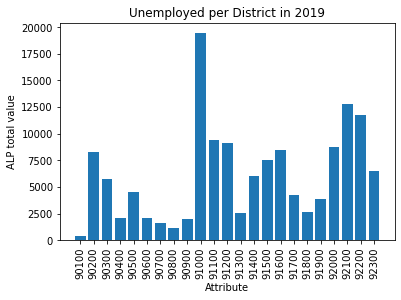

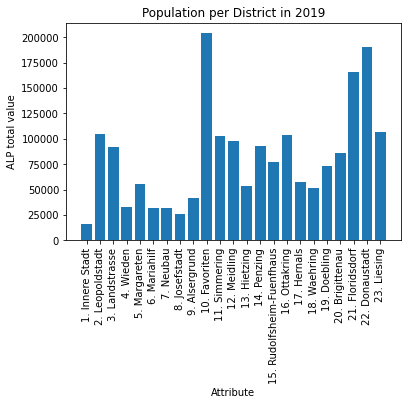

In [30]:
def flatten(t):
    return [item for sublist in t for item in sublist]

# Plot unemployment
attributes = ['90100', '90200', '90300', '90400', '90500', '90600', '90700', '90800', '90900', '91000', '91100', '91200', '91300', '91400', '91500', '91600', '91700', '91800', '91900', '92000', '92100', '92200', '92300']
column_totals = [0] * 23
i = 0
for plz in attributes:
    unemp_dist = unemployment_fromDb[(unemployment_fromDb.DISTRICT_CODE == int(plz)) & (unemployment_fromDb.REF_YEAR == 2019)]
    unemp_dist = unemp_dist["ALP_TOT_VALUE"]
    column_totals[i] = unemp_dist
    i += 1

column_totals = flatten(column_totals)

plt.bar(attributes, column_totals)
plt.title('Unemployed per District in 2019')
plt.xlabel('Attribute')
plt.ylabel('ALP total value')
plt.xticks(rotation=90, horizontalalignment='center')
plt.show()

# Plot population 
population = [0] * 23
i = 0
districts_pop = ['1. Innere Stadt','2. Leopoldstadt','3. Landstrasse','4. Wieden','5. Margareten','6. Mariahilf','7. Neubau','8. Josefstadt','9. Alsergrund','10. Favoriten','11. Simmering','12. Meidling','13. Hietzing','14. Penzing','15. Rudolfsheim-Fuenfhaus','16. Ottakring','17. Hernals','18. Waehring','19. Doebling','20. Brigittenau','21. Floridsdorf','22. Donaustadt','23. Liesing']
for district in districts_pop:
    population_dist = populationGrowth_fromDb[(populationGrowth_fromDb['Jahr'] == 2019)]
    population_dist = population_dist[district]
    #population_dist.columns = ['POPULATION']
    population[i] = population_dist
    i += 1

population = flatten(population)
    
plt.bar(districts_pop, population)
plt.title('Population per District in 2019')
plt.xlabel('Attribute')
plt.ylabel('ALP total value')
plt.xticks(rotation=90, horizontalalignment='center')
plt.show()


### Is there a correlation between unemployment and property prices?
The highest unemployment rate in Vienna is in the 10th district, the lowest in the 1st and 8th district. How will this affect the property prices in this district? We will also analyze if a lower unemployment rate has an positive impact on the development of property prices and if not what other keydrivers could be. First we will analyze the 10th district:

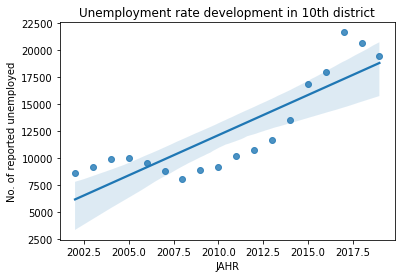

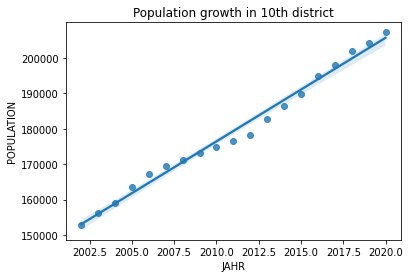

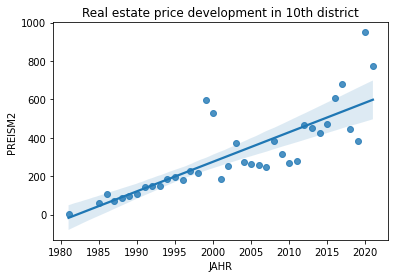

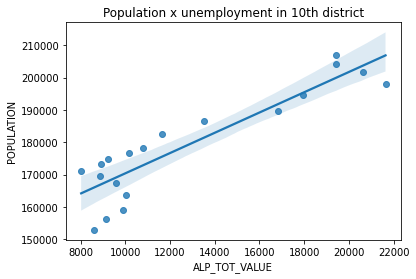

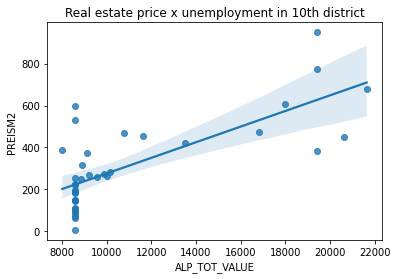

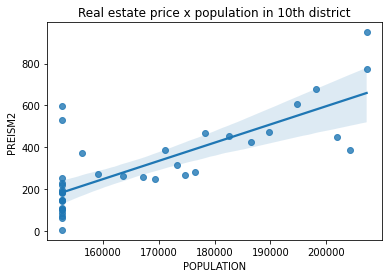

In [31]:
# Plot unemployment
unemp_10th_dist = unemployment_fromDb[unemployment_fromDb['DISTRICT_CODE'] == 91000]
unemp_10th_dist

sns.regplot(x = "REF_YEAR", 
            y = "ALP_TOT_VALUE", 
            data = unemp_10th_dist).set(xlabel='JAHR', ylabel='No. of reported unemployed', title='Unemployment rate development in 10th district')
plt.show()

# Plot population 
population_10th_dist = populationGrowth_fromDb[['Jahr', '10. Favoriten']]
population_10th_dist.columns = ['JAHR', 'POPULATION']

sns.regplot(x = "JAHR", 
            y = "POPULATION", 
            data = population_10th_dist).set(title='Population growth in 10th district')
plt.show()

# Plot real estate sold 
realEstate_10th_dist = realEstateVienna_fromDb[realEstateVienna_fromDb['PLZ'] == 1100]
realEstate_10th_dist['/m² Gfl.']
realEstate_10th_dist['Erwerbsdatum'] = pd.to_datetime(realEstate_10th_dist['Erwerbsdatum'], format = '%d.%m.%Y')
realEstate_10th_dist['Erwerbsdatum'] = realEstate_10th_dist['Erwerbsdatum'].dt.year

# Aggregate to median per year 
realEstate_10th_dist = realEstate_10th_dist[['Erwerbsdatum','/m² Gfl.']]
realEstate_10th_dist.columns = ['JAHR', 'PREISM2']
realEstate_10th_dist = realEstate_10th_dist.groupby(['JAHR'])['PREISM2'].median().reset_index()

sns.regplot(x = "JAHR", 
            y = "PREISM2", 
            data = realEstate_10th_dist).set(title='Real estate price development in 10th district')
plt.show()

# Set index of time series to year for correlation
population_10th_dist.set_index('JAHR', inplace=True)
unemp_10th_dist.set_index('REF_YEAR', inplace=True)
realEstate_10th_dist.set_index('JAHR', inplace=True)

# Correlation  
merged = pd.merge_asof(population_10th_dist, unemp_10th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['POPULATION', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "POPULATION", 
            data = merged).set(title='Population x unemployment in 10th district')
plt.show()

merged = pd.merge_asof(realEstate_10th_dist, unemp_10th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x unemployment in 10th district')
plt.show()

merged = pd.merge_asof(realEstate_10th_dist, population_10th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'POPULATION']]
merged.corr()

sns.regplot(x = "POPULATION", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x population in 10th district')
plt.show()

As you can see, there is everywhere in the 10h district a positive correlation of all evaluated sources.

Now we will do the same for the 8th district (we dont use the 1st district because it is not representive due do its business purpose ond not mainly residential purposes).

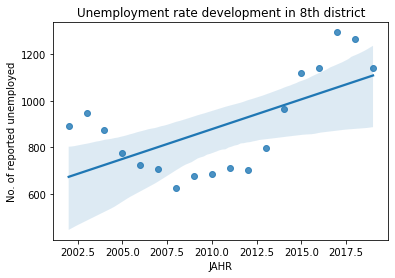

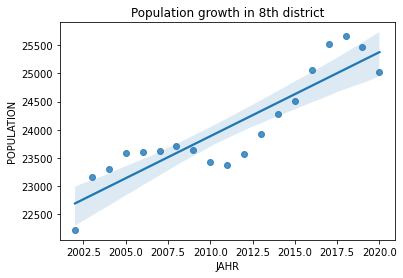

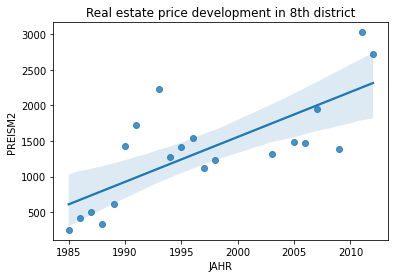

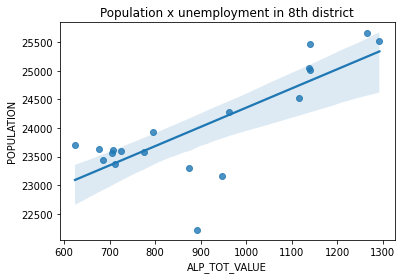

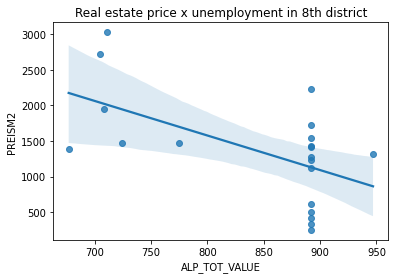

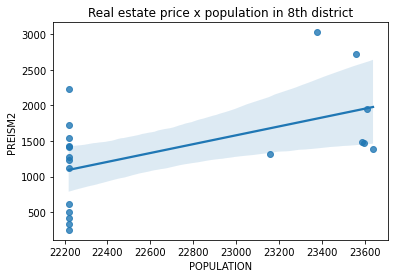

In [32]:
# Plot unemployment
unemp_8th_dist = unemployment_fromDb[unemployment_fromDb['DISTRICT_CODE'] == 90800]
unemp_8th_dist

sns.regplot(x = "REF_YEAR", 
            y = "ALP_TOT_VALUE", 
            data = unemp_8th_dist).set(xlabel='JAHR', ylabel='No. of reported unemployed', title='Unemployment rate development in 8th district')
plt.show()

# Plot population 
population_8th_dist = populationGrowth_fromDb[['Jahr', '8. Josefstadt']]
population_8th_dist.columns = ['JAHR', 'POPULATION']

sns.regplot(x = "JAHR", 
            y = "POPULATION", 
            data = population_8th_dist).set(title='Population growth in 8th district')
plt.show()

# Plot real estate sold 
realEstate_8th_dist = realEstateVienna_fromDb[realEstateVienna_fromDb['PLZ'] == 1080]
realEstate_8th_dist['/m² Gfl.']
realEstate_8th_dist['Erwerbsdatum'] = pd.to_datetime(realEstate_8th_dist['Erwerbsdatum'], format = '%d.%m.%Y')
realEstate_8th_dist['Erwerbsdatum'] = realEstate_8th_dist['Erwerbsdatum'].dt.year

# Aggregate to median per year 
realEstate_8th_dist = realEstate_8th_dist[['Erwerbsdatum','/m² Gfl.']]
realEstate_8th_dist.columns = ['JAHR', 'PREISM2']
realEstate_8th_dist = realEstate_8th_dist.groupby(['JAHR'])['PREISM2'].median().reset_index()

sns.regplot(x = "JAHR", 
            y = "PREISM2", 
            data = realEstate_8th_dist).set(title='Real estate price development in 8th district')
plt.show()

# Set index of time series to year for correlation
population_8th_dist.set_index('JAHR', inplace=True)
unemp_8th_dist.set_index('REF_YEAR', inplace=True)
realEstate_8th_dist.set_index('JAHR', inplace=True)

# Correlation  
merged = pd.merge_asof(population_8th_dist, unemp_8th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['POPULATION', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "POPULATION", 
            data = merged).set(title='Population x unemployment in 8th district')
plt.show()

merged = pd.merge_asof(realEstate_8th_dist, unemp_8th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x unemployment in 8th district')
plt.show()

merged = pd.merge_asof(realEstate_8th_dist, population_8th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'POPULATION']]
merged.corr()

sns.regplot(x = "POPULATION", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x population in 8th district')
plt.show()

Here is one thing a bit strange: We have a negative correlation between the real estate prices and the unemployment - acording to our assumption it should be the other way aorund like in the 10th district.

Lets take a deeper look at the correlations.

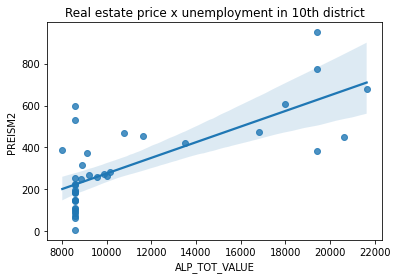

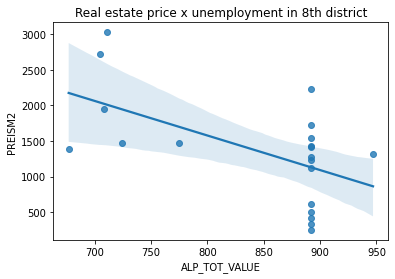

In [33]:
merged = pd.merge_asof(realEstate_10th_dist, unemp_10th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x unemployment in 10th district')
plt.show()


merged = pd.merge_asof(realEstate_8th_dist, unemp_8th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'ALP_TOT_VALUE']]
merged.corr()

sns.regplot(x = "ALP_TOT_VALUE", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x unemployment in 8th district')
plt.show()


## MapReduce: Correlation analysis 
In this step of our analysis, we are going to calculate the Pearson, Spearman and Kendall correlation coefficients between population growth and real estate pricing in all districts of Vienna! 

For this, we'll use Mr. Job and construct a proper mapper and reducer. 

In the map step, we aggregate our data grouped by district of Vienna into a shared data frame for processing, in the reducer step we calculate all three types of correlation coefficient per district.

In [34]:
%%file correlationCalc.py
from mrjob.job import MRJob
from pymongo import MongoClient
import pandas as pd
import sys

# Connect to DB
CONNECTION_STRING = "mongodb://127.0.0.1:27017"
myclient = MongoClient(CONNECTION_STRING)
db = myclient["immodb"]

# Get data from DB
unemployment_fromDb = pd.DataFrame(list(db["unemploymentData"].find()))
unemployment_fromDb = unemployment_fromDb.set_index("_id")
        
# Define MapReduce
class CorrelationCalc(MRJob):  
    def mapper(self, _, line):
        # Get data from DB
        realEstateVienna_fromDb = pd.DataFrame(list(db["realEstateVienna"].find()))
        realEstateVienna_fromDb = realEstateVienna_fromDb.set_index("_id")

        # Clean Data
        realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['ber. Kaufpreis'].isnull()]
        realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['Erwerbsdatum'].isnull()]
        realEstateVienna_fromDb = realEstateVienna_fromDb[~realEstateVienna_fromDb['/m² Gfl.'].isnull()]
        realEstateVienna_fromDb = realEstateVienna_fromDb[realEstateVienna_fromDb['/m² Gfl.'] > 0]

        line = line.split(',')
        unemp_dist = unemployment_fromDb[unemployment_fromDb['DISTRICT_CODE'] == int(line[0])]
        unemp_dist.set_index('REF_YEAR', inplace=True)
    
        realEstateVienna_fromDb = realEstateVienna_fromDb[realEstateVienna_fromDb['PLZ'] == int(line[2])]
        realEstateVienna_fromDb['Erwerbsdatum'] = realEstateVienna_fromDb['Erwerbsdatum'].str.slice(6,10)

        # Aggregate to median per year 
        realEstateVienna_fromDb = realEstateVienna_fromDb[['Erwerbsdatum','/m² Gfl.']]
        realEstateVienna_fromDb.columns = ['JAHR', 'PREISM2']
        realEstateVienna_fromDb['JAHR'] = realEstateVienna_fromDb['JAHR'].astype('int32')
        realEstateVienna_fromDb = realEstateVienna_fromDb.groupby(['JAHR'])['PREISM2'].median().reset_index()
        realEstateVienna_fromDb.set_index('JAHR', inplace=True)

        districtData = pd.merge_asof(realEstateVienna_fromDb, unemp_dist, left_index=True, right_index=True, direction='nearest')
        districtData = districtData[['PREISM2', 'ALP_TOT_VALUE']]
                
        yield (line[0], (districtData.corr(method='pearson')['ALP_TOT_VALUE']['PREISM2'], districtData.corr(method='spearman')['ALP_TOT_VALUE']['PREISM2'], districtData.corr(method='kendall')['ALP_TOT_VALUE']['PREISM2']))

    def reducer(self, districtCode, districtData):
        yield (districtCode, next(districtData))
        
if __name__ == '__main__':
    CorrelationCalc.run()

Writing correlationCalc.py


In [35]:
!python correlationCalc.py ./district.data

  File "correlationCalc.py", line 25
SyntaxError: Non-ASCII character '\xc2' in file correlationCalc.py on line 25, but no encoding declared; see http://python.org/dev/peps/pep-0263/ for details


### Do we have a spurious statistical relationship in our data?
When we look at the correlation of real estate prices to unemployed people we see that higher unemployment in the 8th district leads to lower real estate prices. But in the 10th district it is the other way around: higher unemployment in the 10th district leads to higher real estate prices. This does not really make sense and sounds like a nonsense correlation (spurious statistical relationship). So what can the other key drivers be? Lets look at the correlation between real estate prices and population.

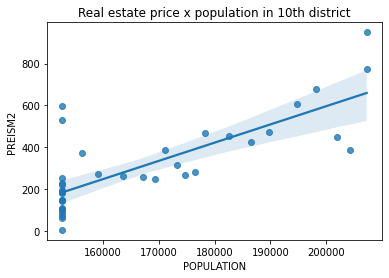

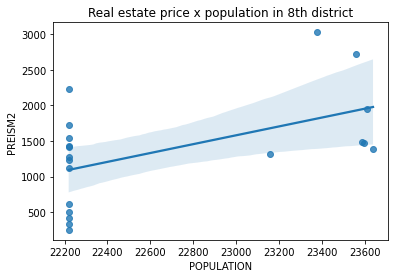

In [36]:
merged = pd.merge_asof(realEstate_10th_dist, population_10th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'POPULATION']]
merged.corr()

sns.regplot(x = "POPULATION", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x population in 10th district')
plt.show()

merged = pd.merge_asof(realEstate_8th_dist, population_8th_dist, left_index=True, right_index=True, direction='nearest')
merged = merged[['PREISM2', 'POPULATION']]
merged.corr()

sns.regplot(x = "POPULATION", 
            y = "PREISM2", 
            data = merged).set(title='Real estate price x population in 8th district')
plt.show()

## Conclusion: What's the real key driver for the rising real estate prices in Vienna?

We can see, that just population is the key driver for real estate prices. The 10th district had a much higher population growth than the 8th district over time. We will use the population growth of each district to forecast the future price development for the real estate prices in each district of Vienna.

## All Districts - in  what way are our datasets connected?
Now we analyze all the districts - how did they change over time?
At first we plot the unemployment rate per district, then we plot the population growth and at last the real estate prices.

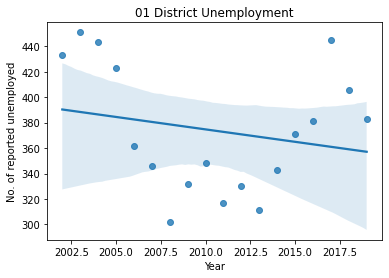

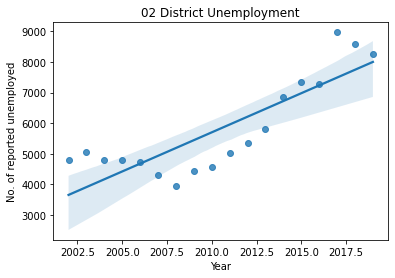

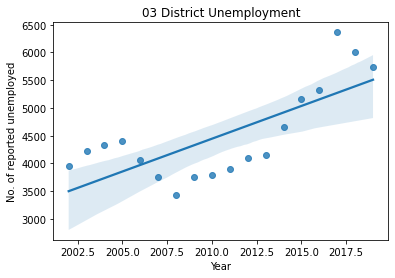

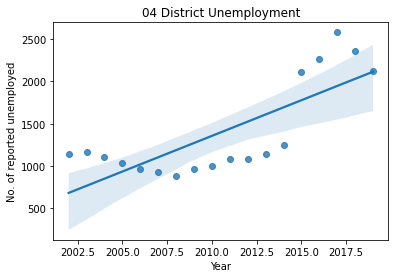

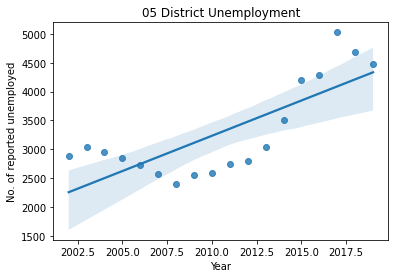

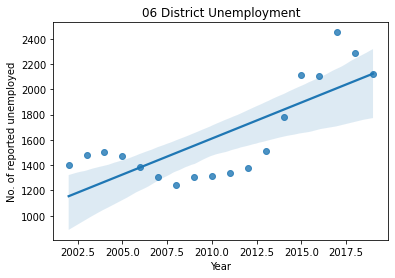

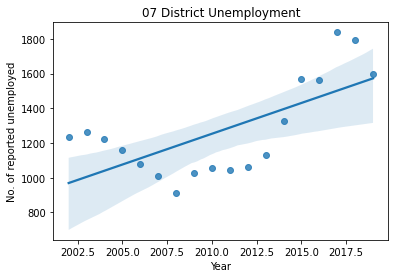

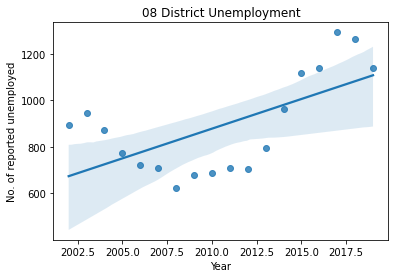

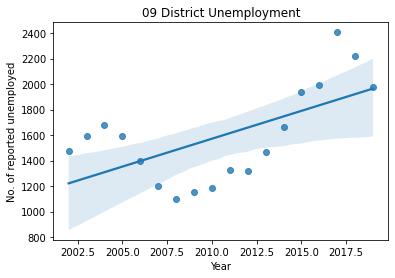

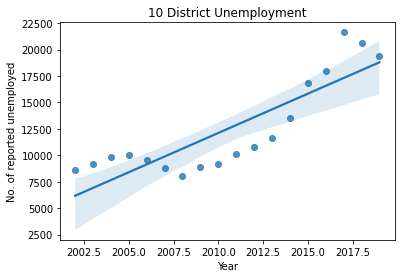

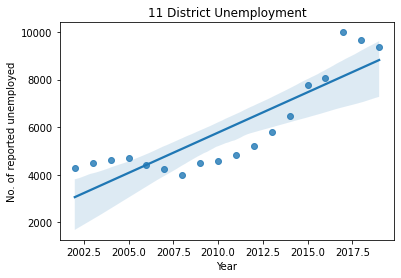

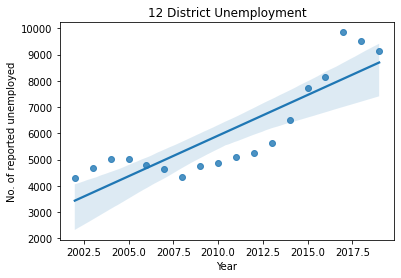

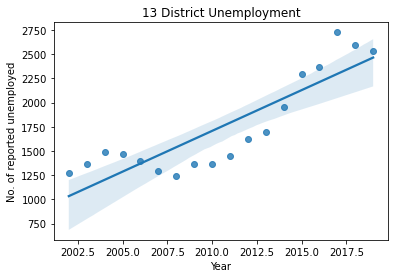

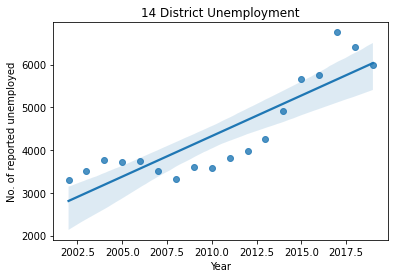

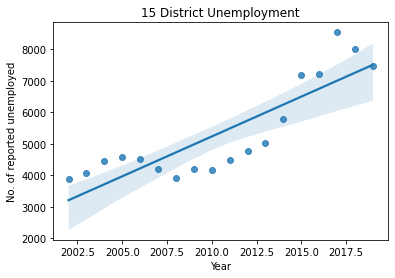

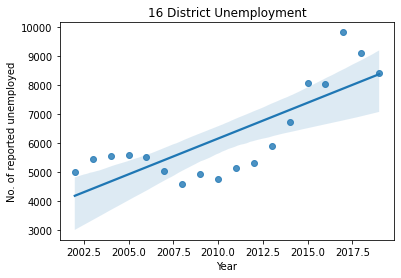

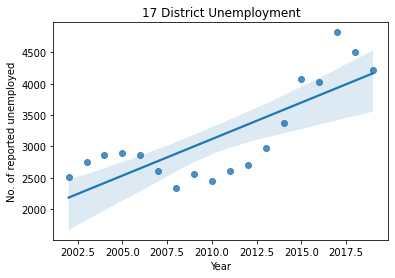

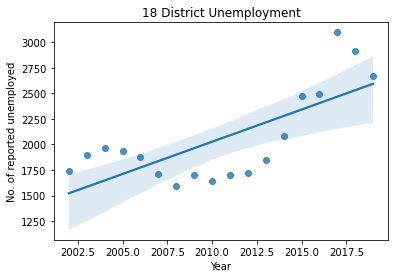

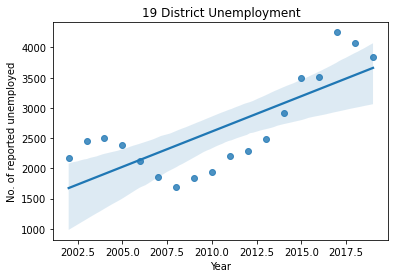

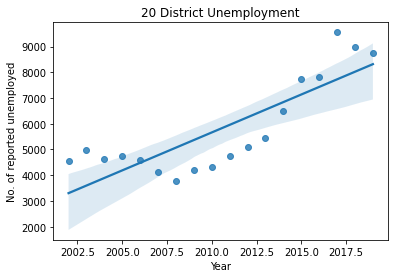

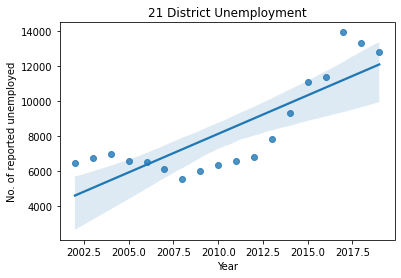

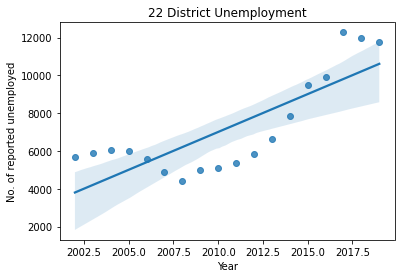

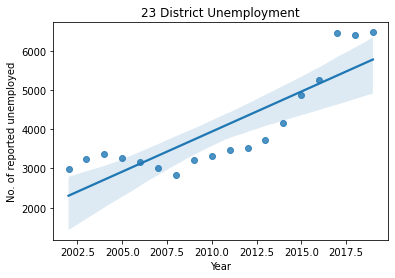

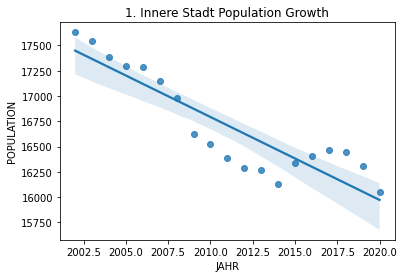

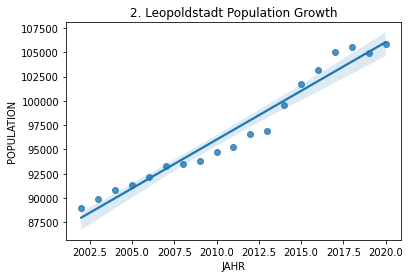

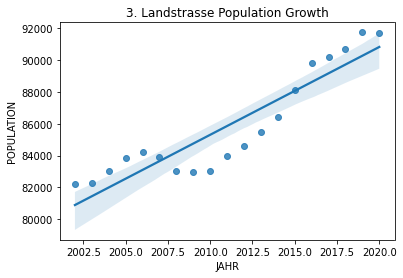

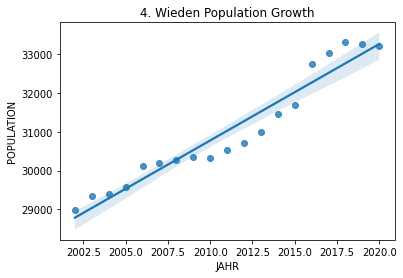

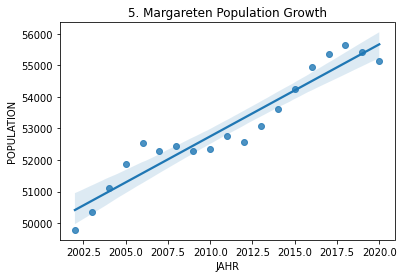

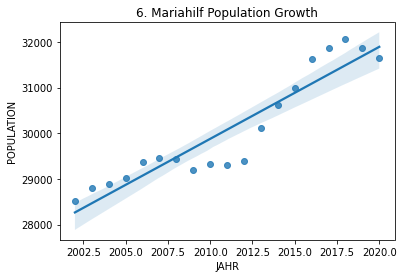

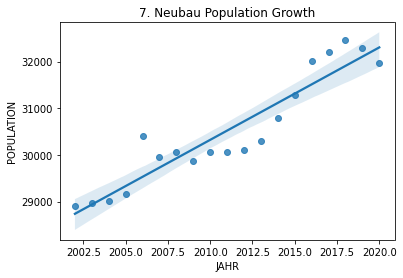

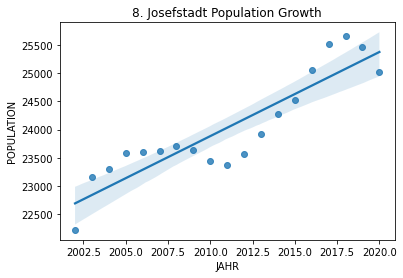

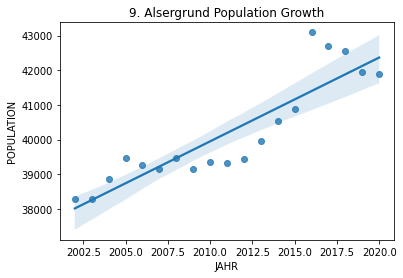

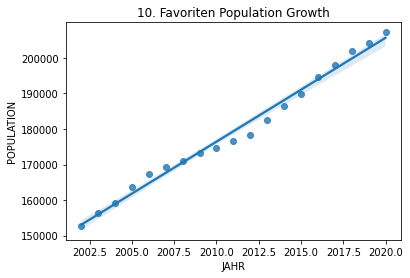

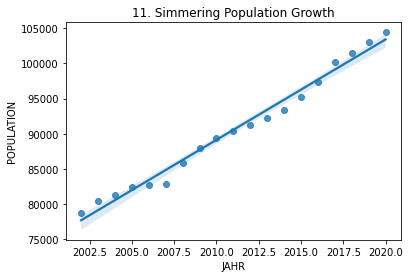

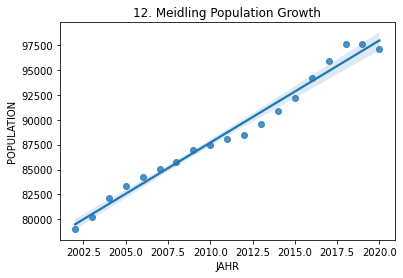

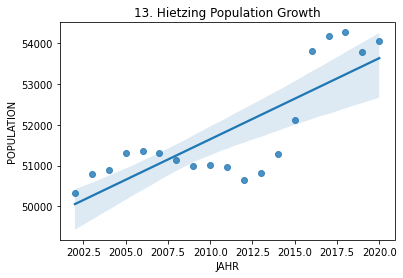

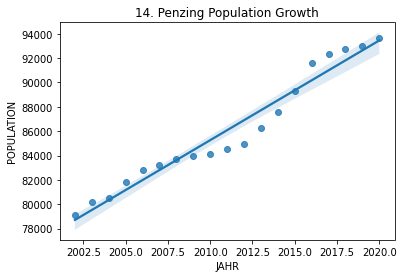

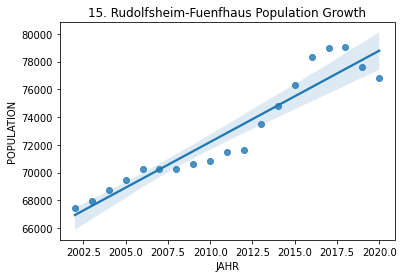

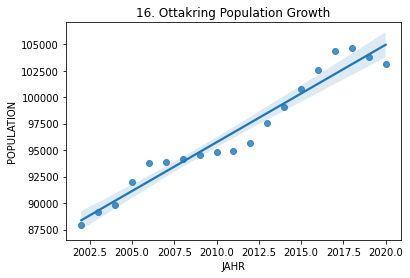

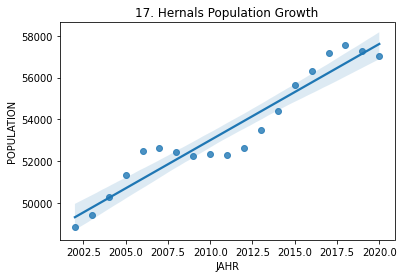

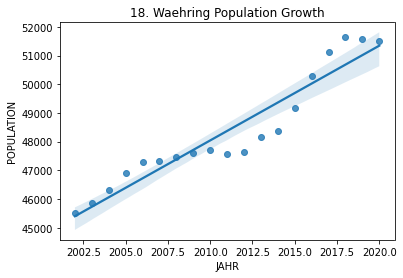

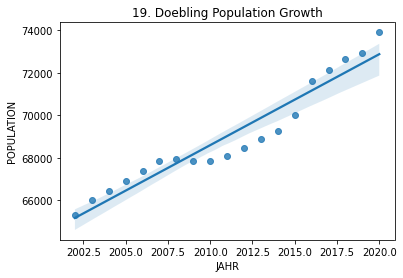

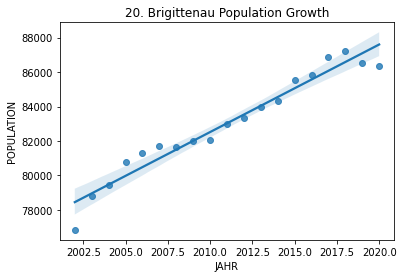

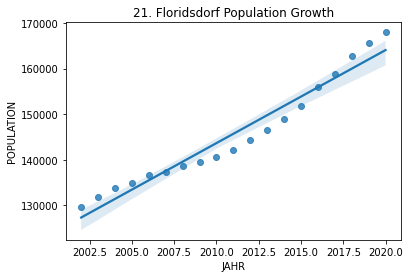

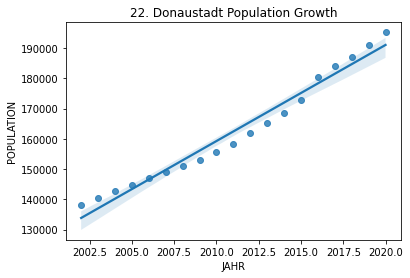

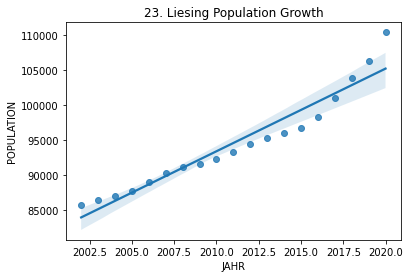

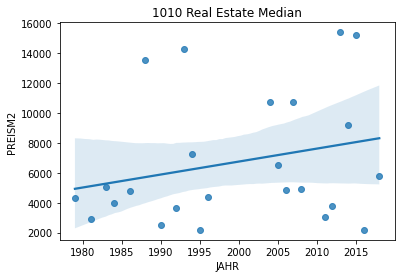

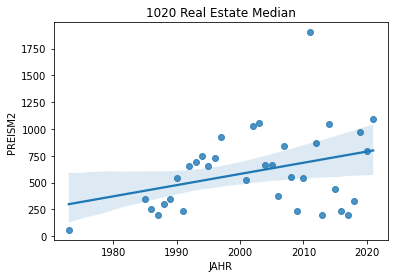

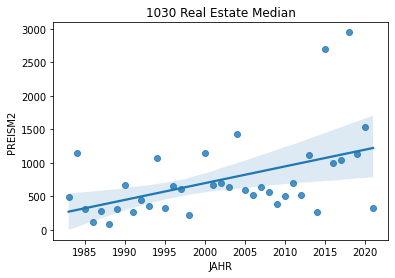

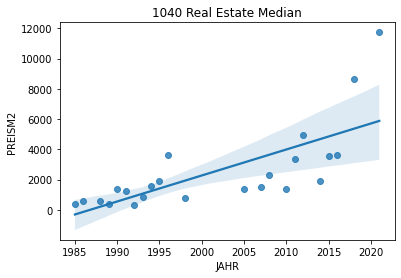

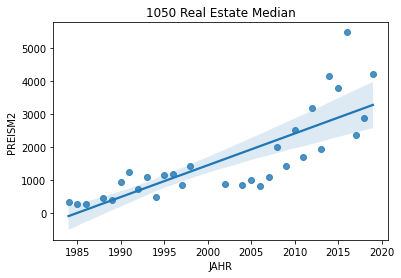

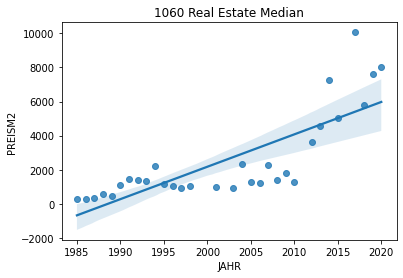

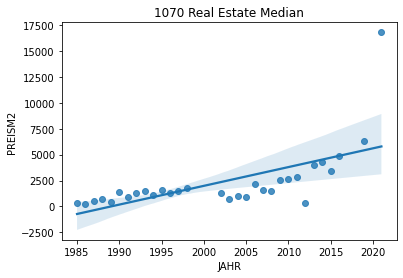

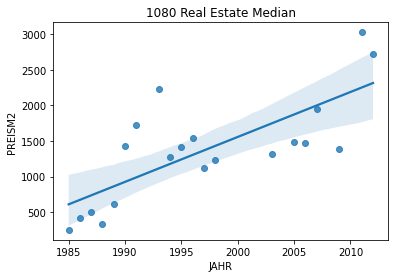

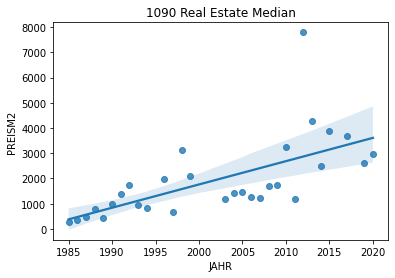

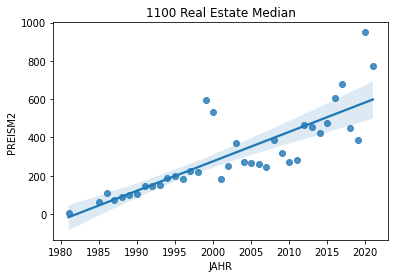

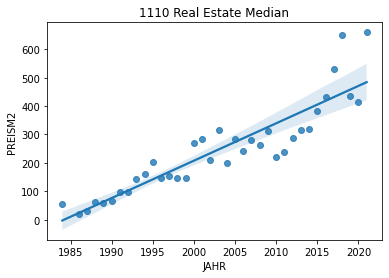

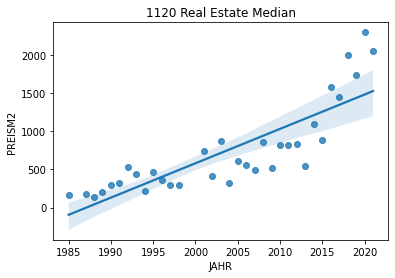

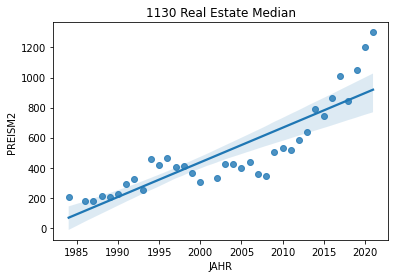

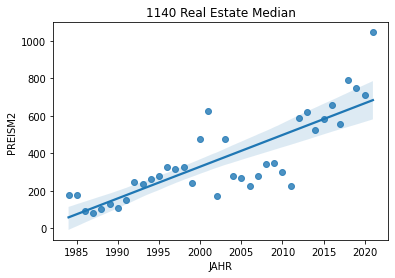

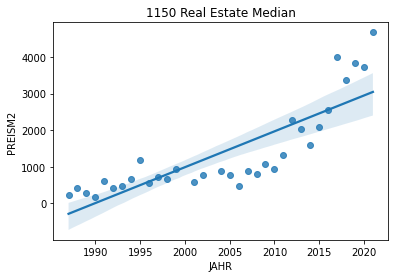

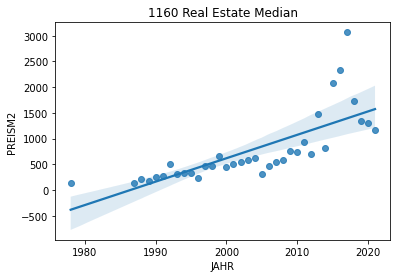

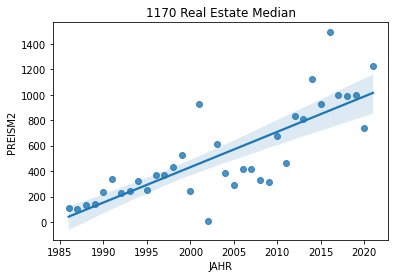

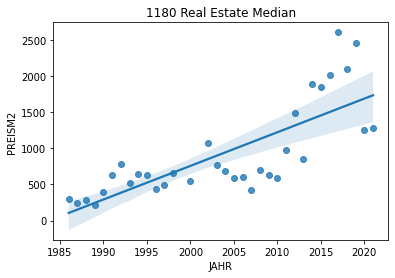

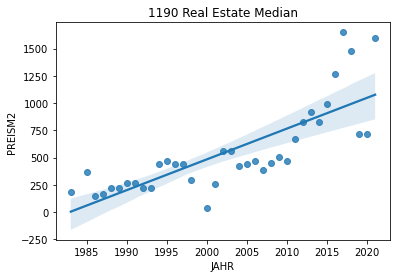

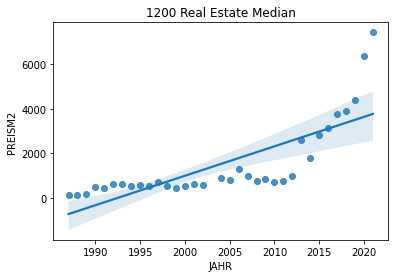

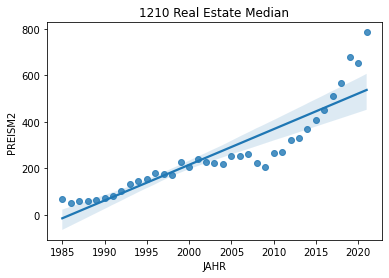

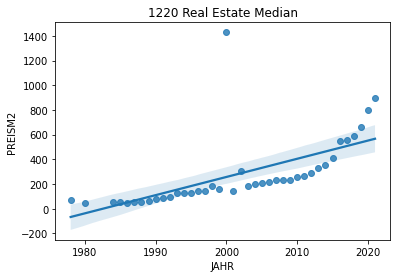

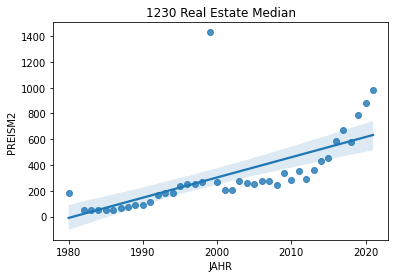

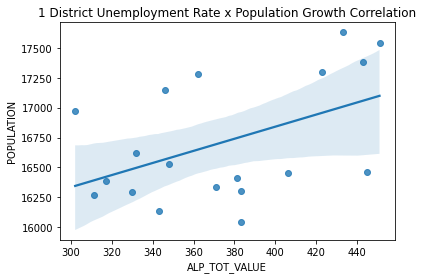

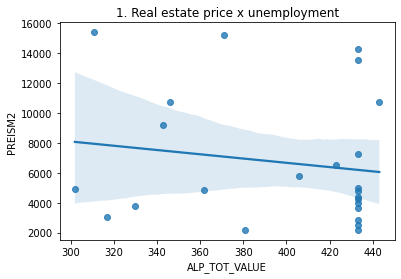

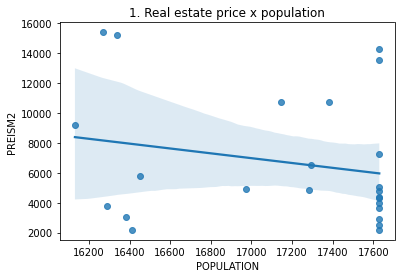

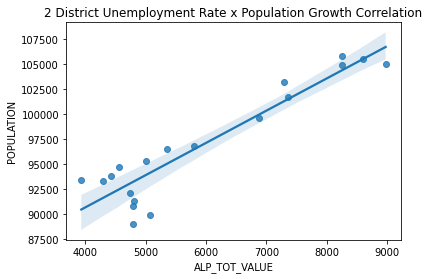

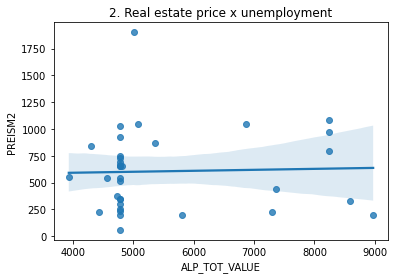

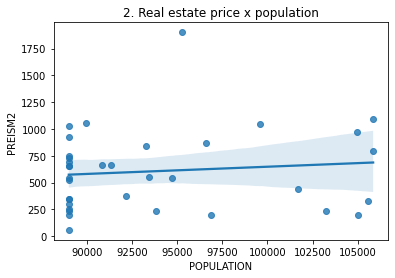

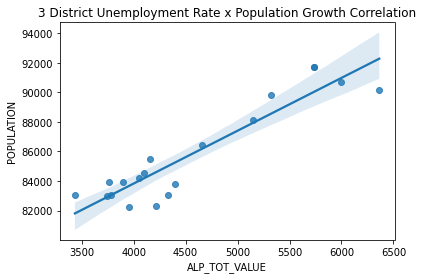

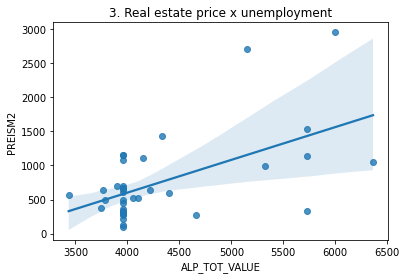

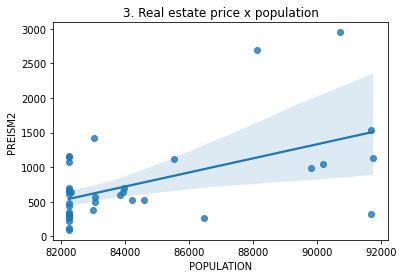

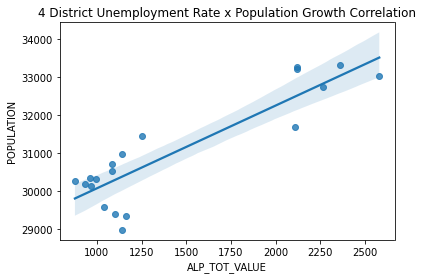

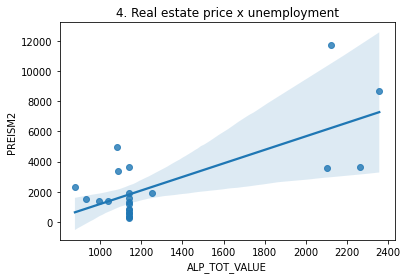

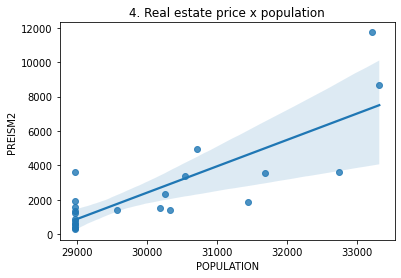

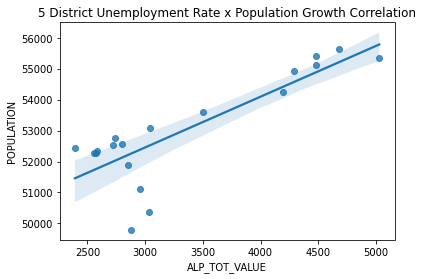

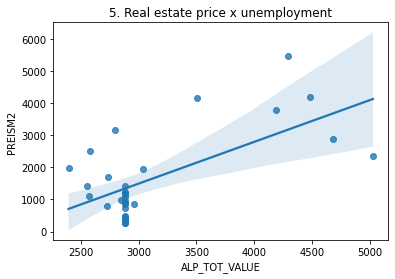

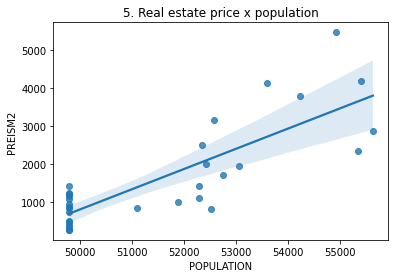

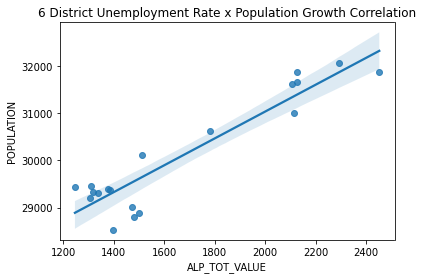

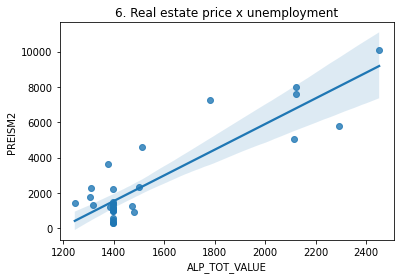

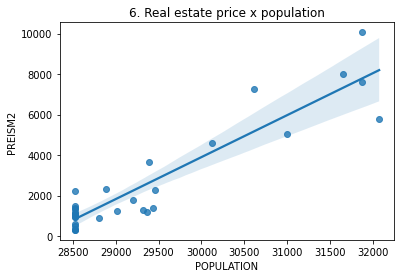

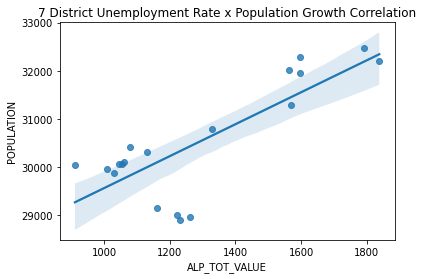

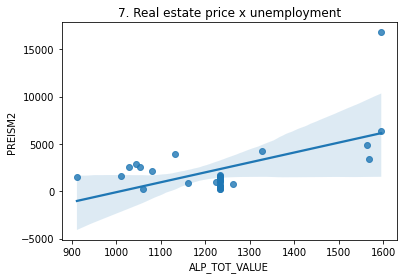

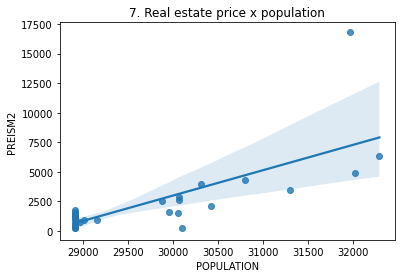

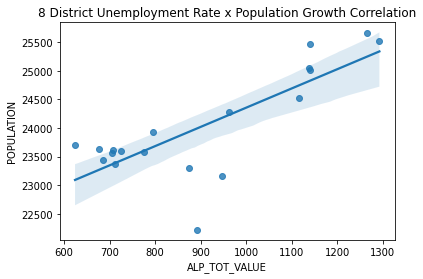

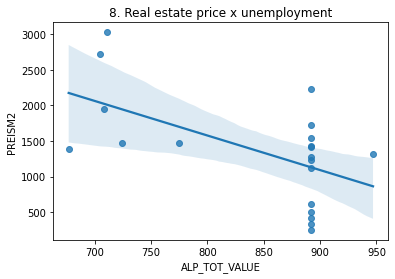

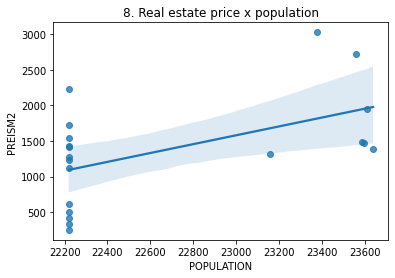

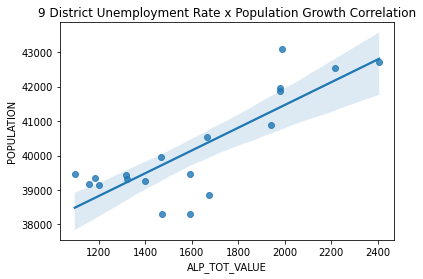

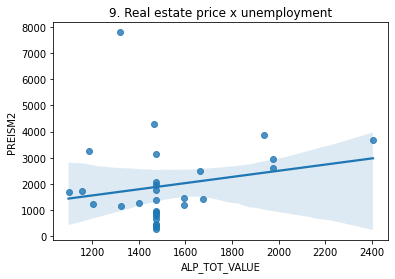

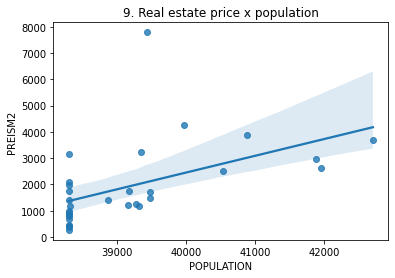

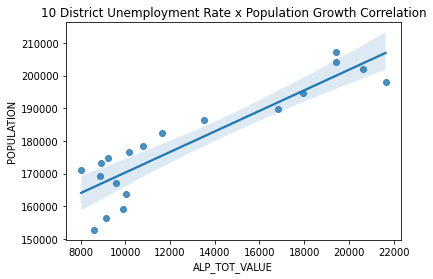

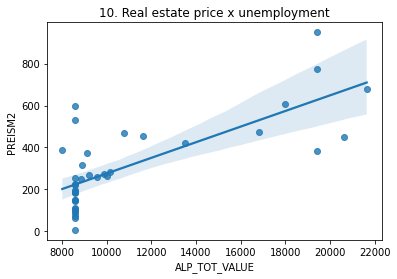

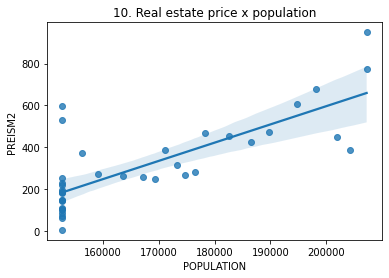

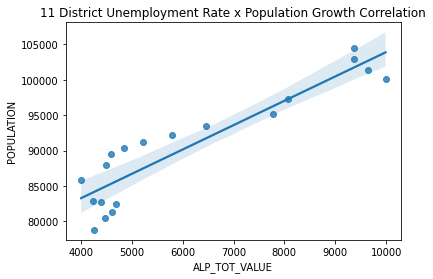

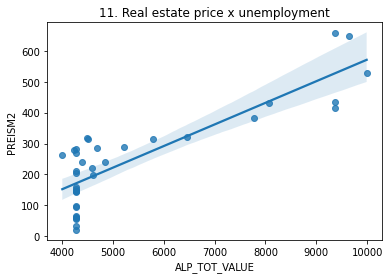

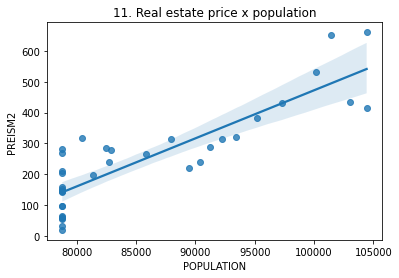

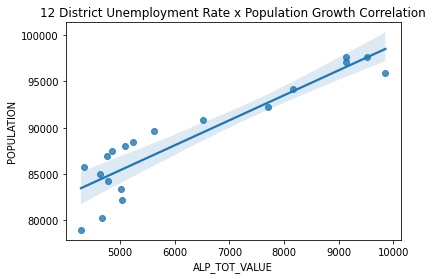

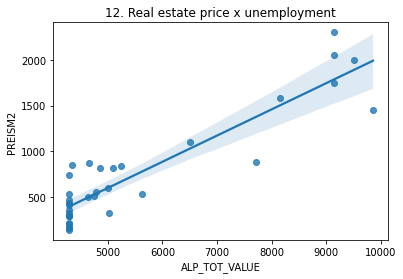

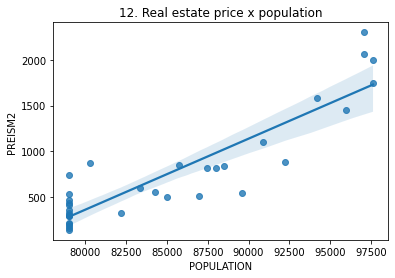

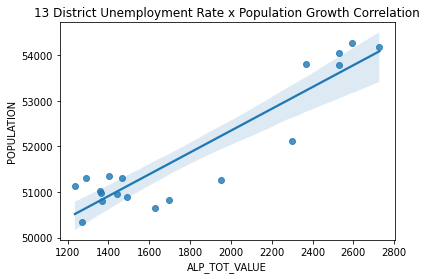

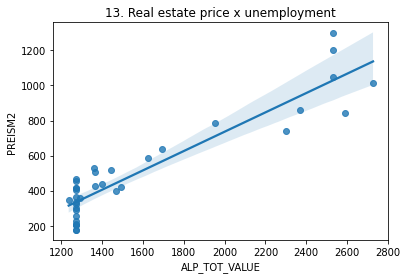

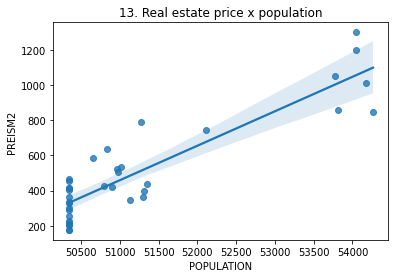

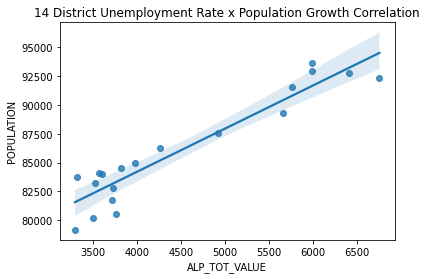

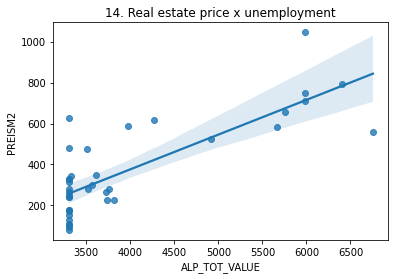

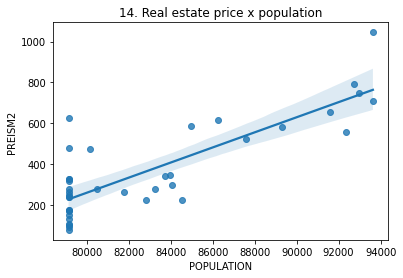

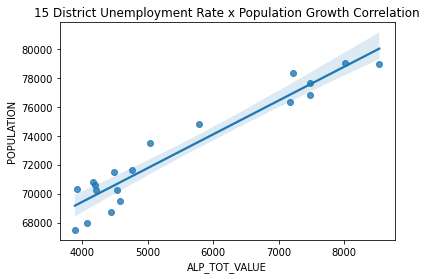

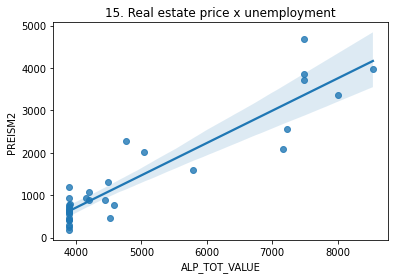

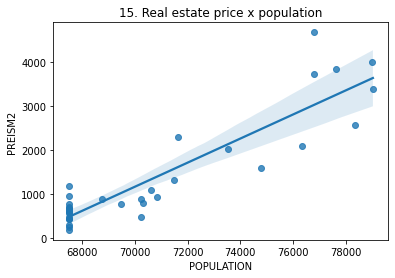

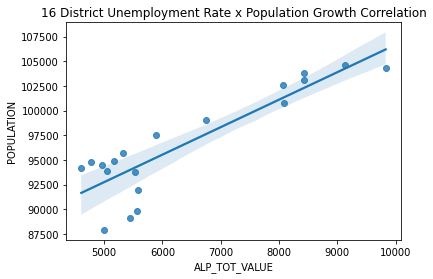

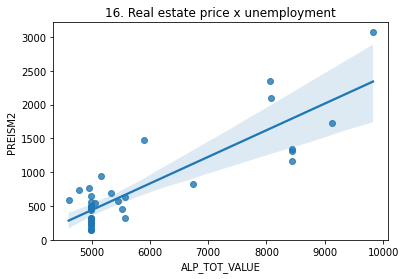

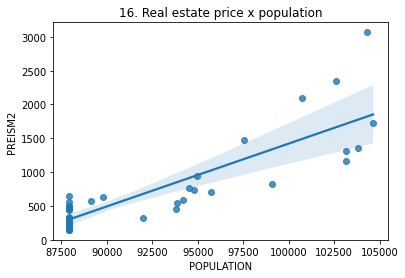

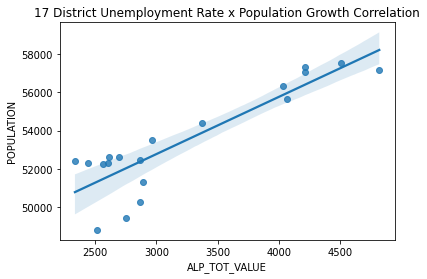

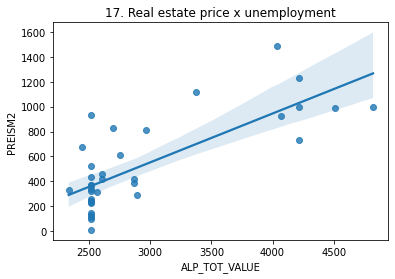

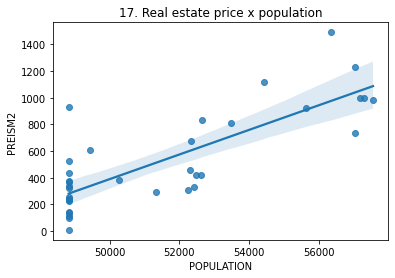

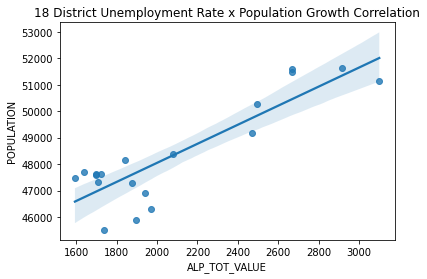

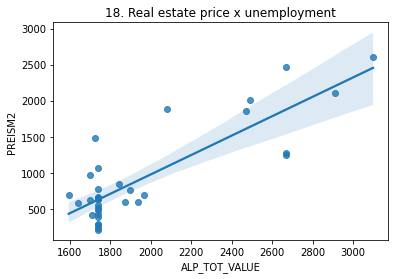

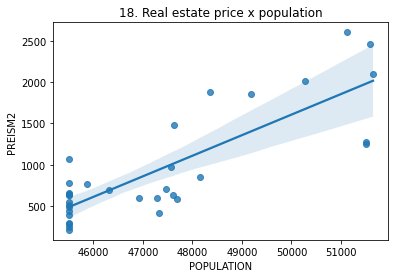

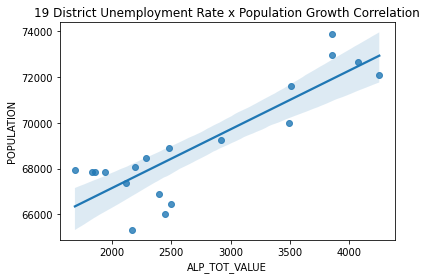

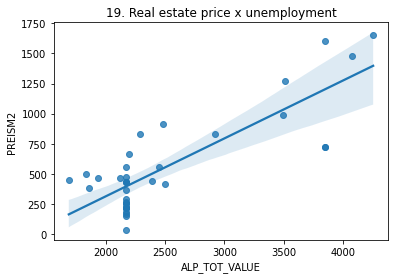

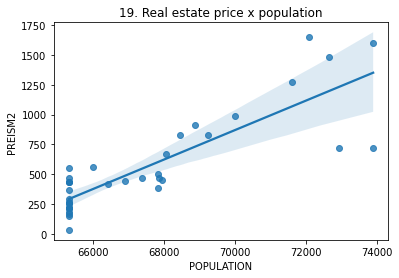

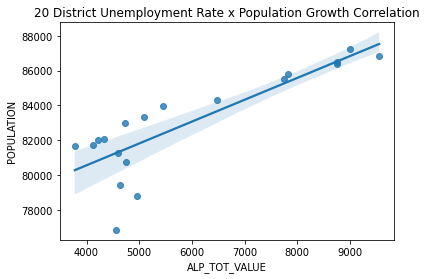

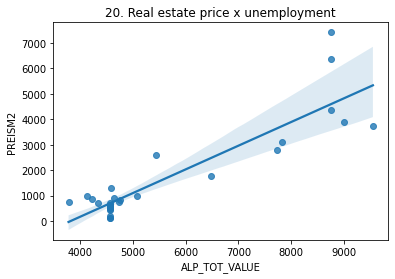

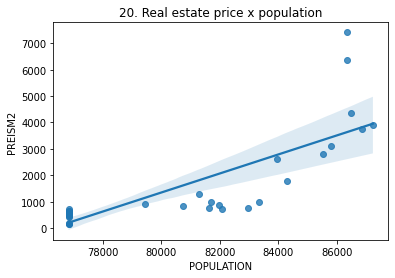

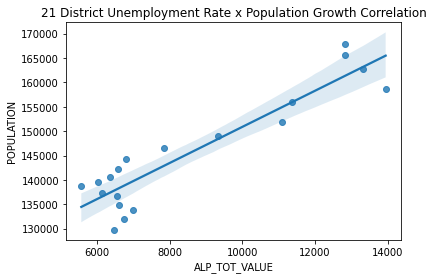

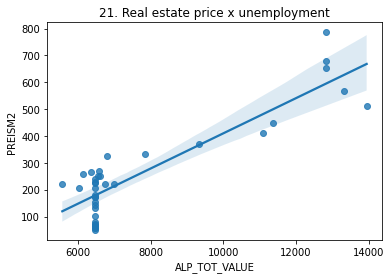

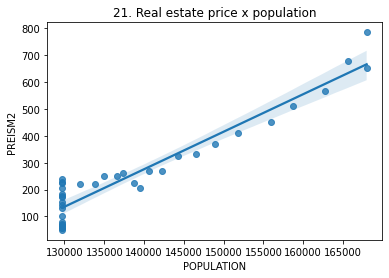

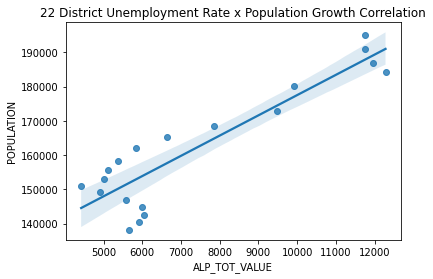

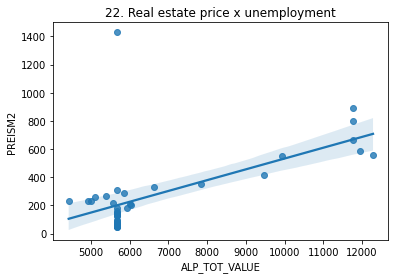

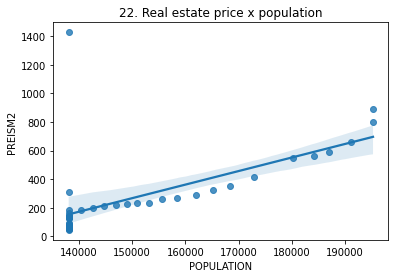

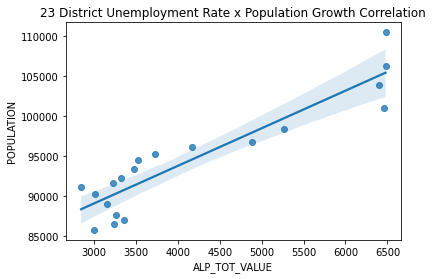

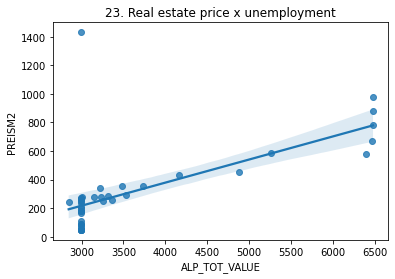

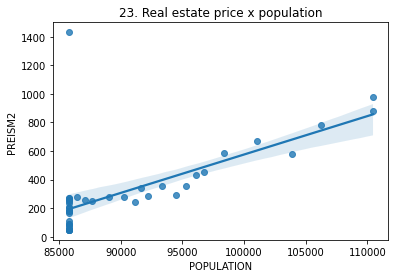

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot unemployment
unemployment = [0] * 23
i = 0
districts_unemp = [90100, 90200, 90300, 90400, 90500, 90600, 90700, 90800, 90900, 91000, 91100, 91200, 91300, 91400, 91500, 91600, 91700, 91800, 91900, 92000, 92100, 92200, 92300]
for plz in districts_unemp:
    unemp_dist = unemployment_fromDb[unemployment_fromDb['DISTRICT_CODE'] == plz]
    unemployment[i] = unemp_dist
    i += 1
    
    sns.regplot(x = "REF_YEAR", 
                y = "ALP_TOT_VALUE", 
                data = unemp_dist).set(xlabel='Year', ylabel='No. of reported unemployed', title=str(plz)[1:3] + ' District Unemployment')
    plt.show()
    

# Plot population 
population = [0] * 23
i = 0
districts_pop = ['1. Innere Stadt','2. Leopoldstadt','3. Landstrasse','4. Wieden','5. Margareten','6. Mariahilf','7. Neubau','8. Josefstadt','9. Alsergrund','10. Favoriten','11. Simmering','12. Meidling','13. Hietzing','14. Penzing','15. Rudolfsheim-Fuenfhaus','16. Ottakring','17. Hernals','18. Waehring','19. Doebling','20. Brigittenau','21. Floridsdorf','22. Donaustadt','23. Liesing']
for district in districts_pop:
    population_dist = populationGrowth_fromDb[['Jahr', district]]
    population_dist.columns = ['JAHR', 'POPULATION']
    population[i] = population_dist
    i += 1

    sns.regplot(x = "JAHR", 
                y = "POPULATION", 
                data = population_dist).set(title=district +' Population Growth')
    plt.show()

# Plot real estate sold 
realestate = [0] * 23
i = 0
districts_realEstate = [1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230]
for plz in districts_realEstate:
    realEstate_dist = realEstateVienna_fromDb[realEstateVienna_fromDb['PLZ'] == plz]
    realEstate_dist['/m² Gfl.']
    realEstate_dist['Erwerbsdatum'] = pd.to_datetime(realEstate_dist['Erwerbsdatum'], format = '%d.%m.%Y')
    realEstate_dist['Erwerbsdatum'] = realEstate_dist['Erwerbsdatum'].dt.year

    # Aggregate to median per year 
    realEstate_dist = realEstate_dist[['Erwerbsdatum','/m² Gfl.']]
    realEstate_dist.columns = ['JAHR', 'PREISM2']
    realEstate_dist = realEstate_dist.groupby(['JAHR'])['PREISM2'].median().reset_index()
    realestate[i] = realEstate_dist
    i += 1

    sns.regplot(x = "JAHR", 
                y = "PREISM2", 
                data = realEstate_dist).set(title=str(plz) + ' Real Estate Median')
    plt.show()

for i in range(0,23):
    # Set index of time series to year for correlation
    population[i].set_index('JAHR', inplace=True)
    unemployment[i].set_index('REF_YEAR', inplace=True)
    realestate[i].set_index('JAHR', inplace=True)

    # Correlation graph
    merged = pd.merge_asof(population[i], unemployment[i], left_index=True, right_index=True, direction='nearest')
    merged = merged[['POPULATION', 'ALP_TOT_VALUE']]

    sns.regplot(x = "ALP_TOT_VALUE", 
                y = "POPULATION", 
                data = merged).set(title=str(i+1) + ' District Unemployment Rate x Population Growth Correlation')
    plt.show()
    
    
    
    merged = pd.merge_asof(realestate[i], unemployment[i], left_index=True, right_index=True, direction='nearest')
    merged = merged[['PREISM2', 'ALP_TOT_VALUE']]

    sns.regplot(x = "ALP_TOT_VALUE", 
                y = "PREISM2", 
                data = merged).set(title=str(i+1) + '. Real estate price x unemployment')
    plt.show()

    merged = pd.merge_asof(realestate[i], population[i], left_index=True, right_index=True, direction='nearest')
    merged = merged[['PREISM2', 'POPULATION']]

    sns.regplot(x = "POPULATION", 
                y = "PREISM2", 
                data = merged).set(title=str(i+1) + '. Real estate price x population')
    plt.show()

## Forecasting Real Estate Prices
Now we shall take a look into the future!
We'll take a look at how real estate prices are going to probably develop in the coming five years.

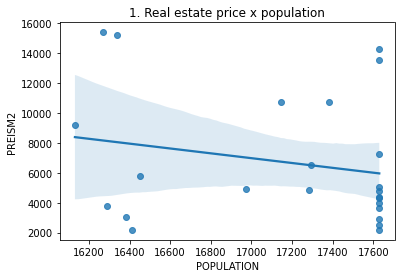

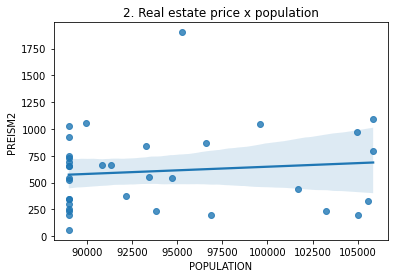

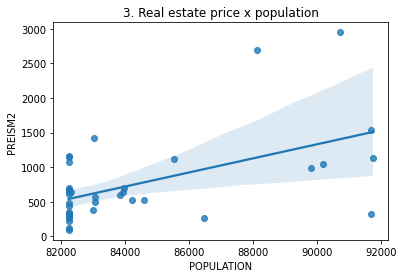

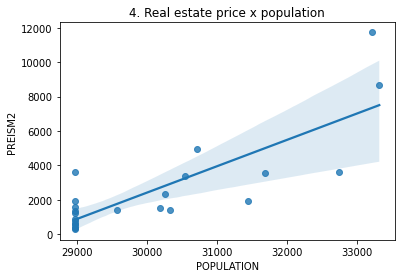

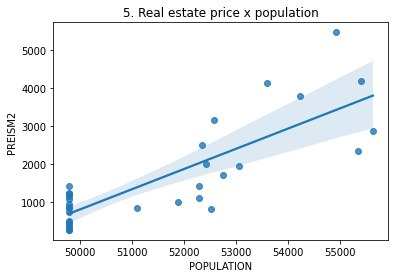

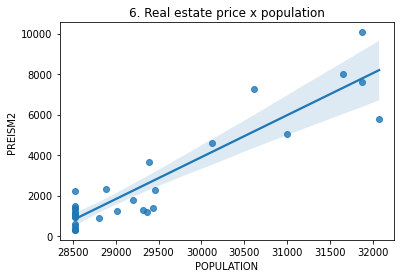

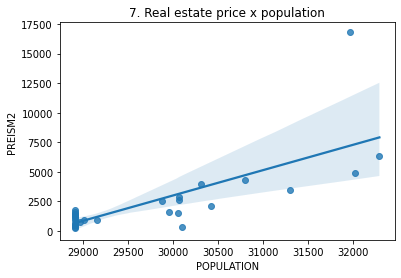

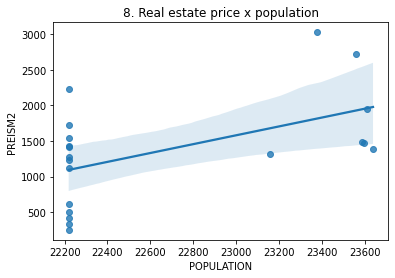

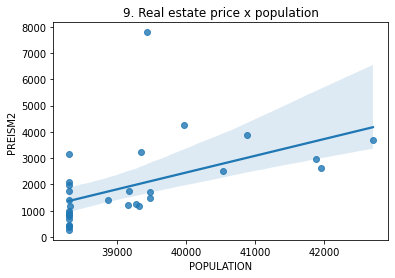

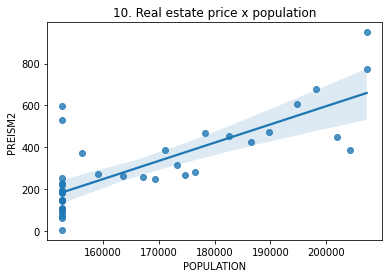

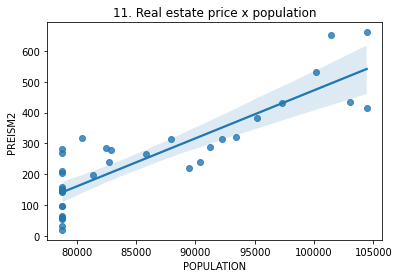

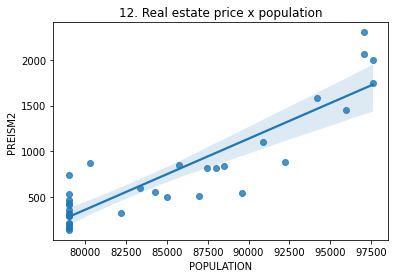

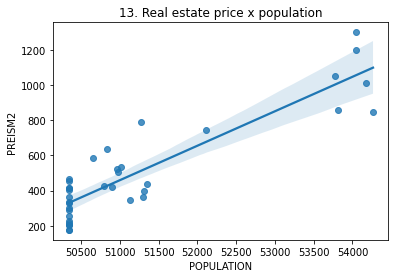

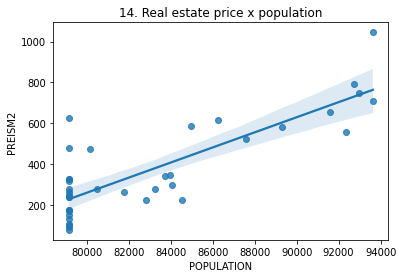

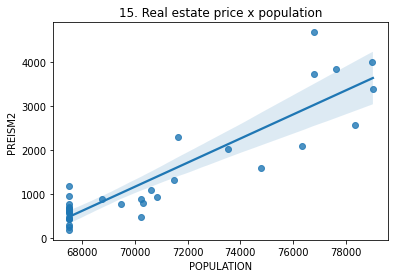

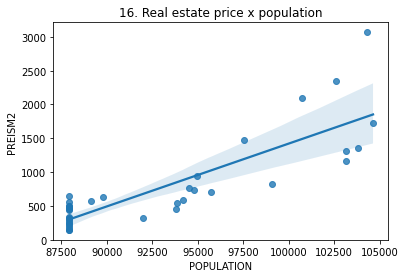

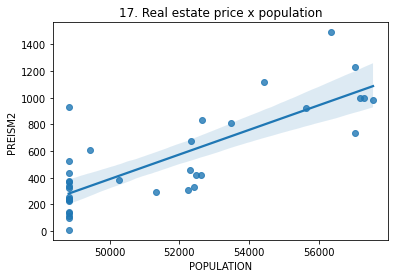

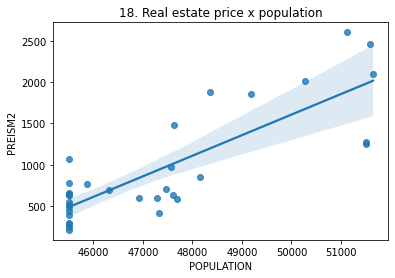

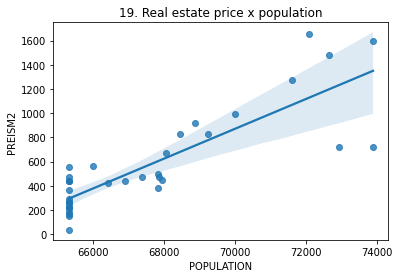

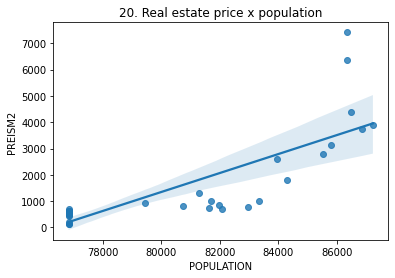

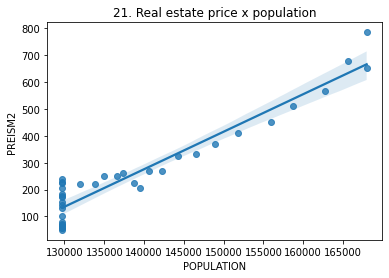

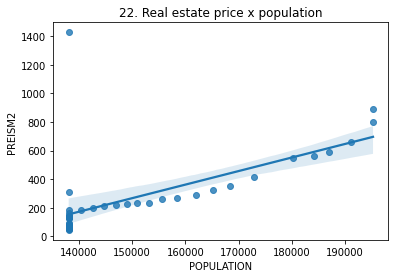

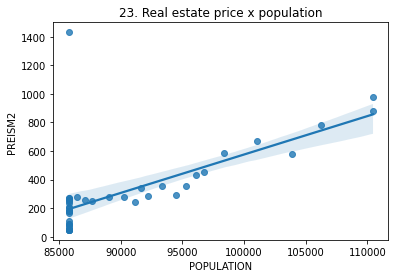

In [38]:
for i in range(0,23):
    # Correlation graph
    merged = pd.merge_asof(realestate[i], population[i], left_index=True, right_index=True, direction='nearest')
    merged = merged[['PREISM2', 'POPULATION']]

    sns.regplot(x = "POPULATION", 
                y = "PREISM2", 
                data = merged).set(title=str(i+1) + '. Real estate price x population')
    plt.show()

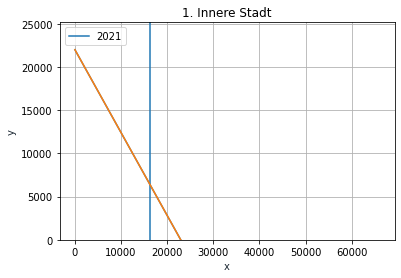

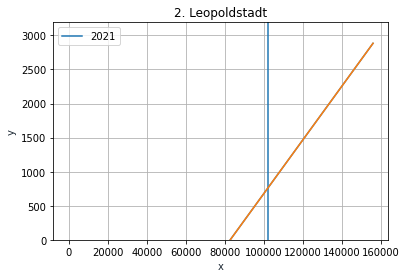

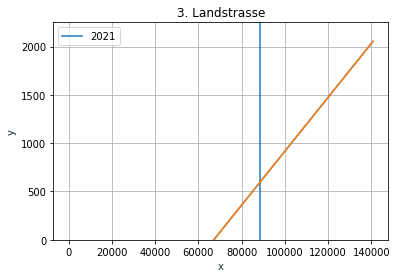

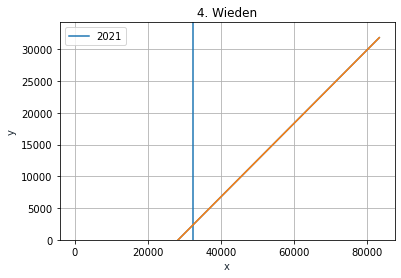

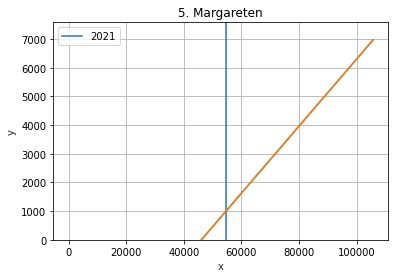

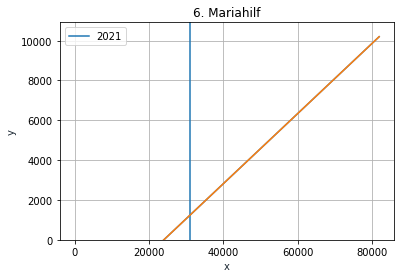

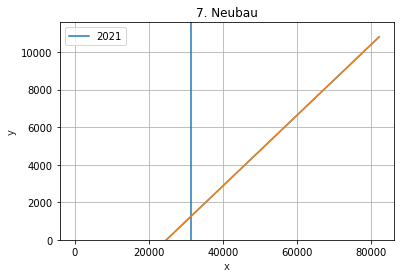

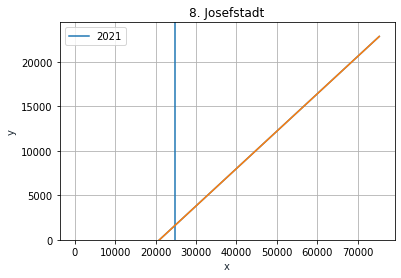

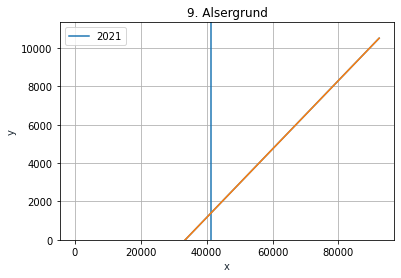

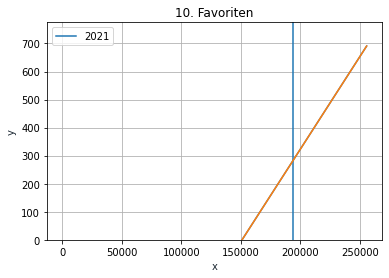

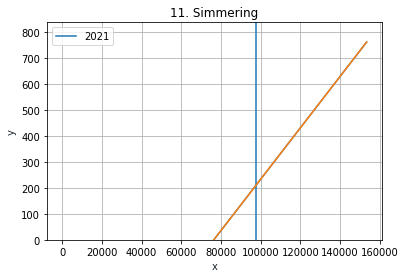

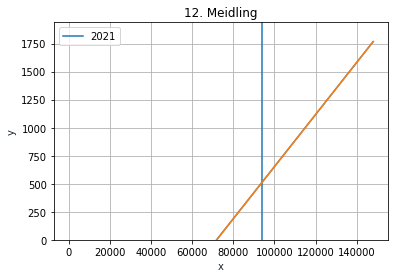

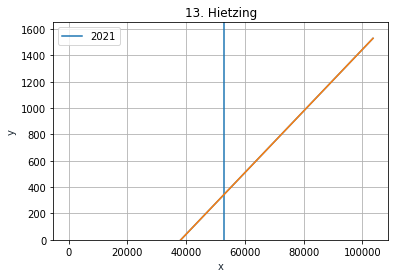

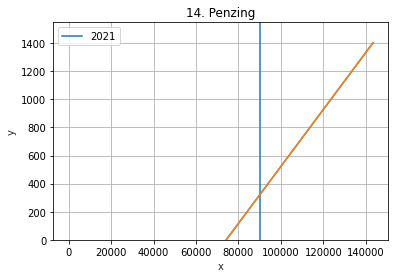

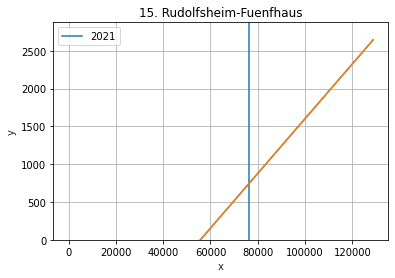

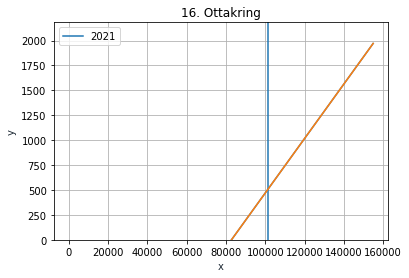

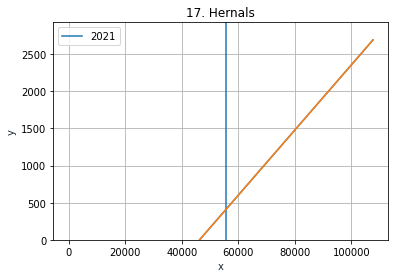

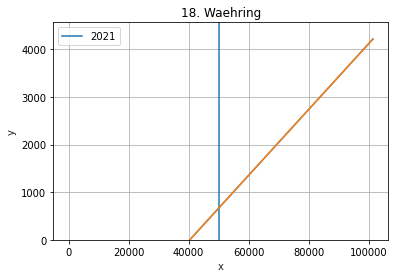

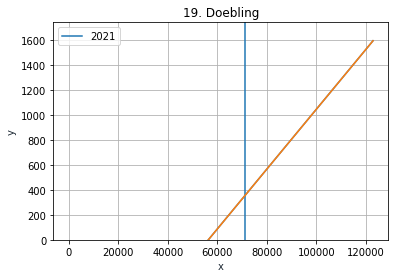

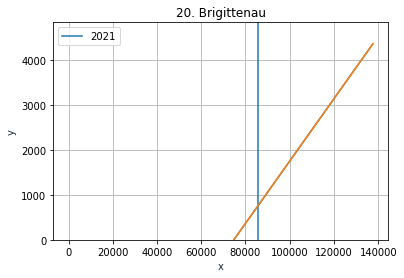

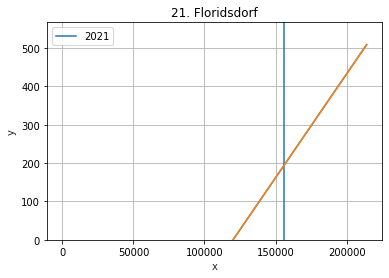

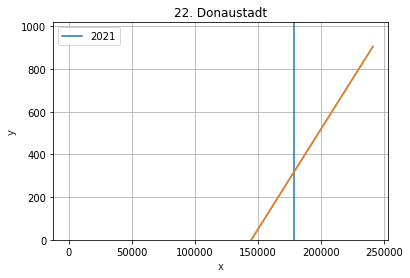

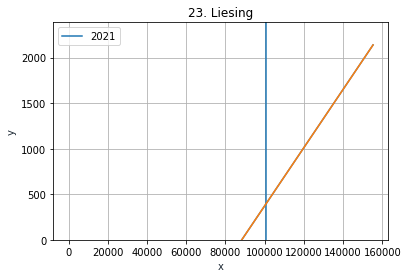

In [39]:
for district in range(0,23):
    # Forecast population for next 5 years based on linear model
    k, d = np.polyfit(range(2002,2021), population[district]['POPULATION'], 1)
    popForecast = [0] * 30
    for i in range(-25, 5):
        popForecast[i] = k*(2021+i)+d

    # Forecast real estate prices for the next 5 years based on population growth
    k, d, r_value, pv, se = stats.linregress(population[district]['POPULATION'], realestate[district]['PREISM2'][:19])
    priceForecast = [0] * 5
    for i in range(0, 5):
        priceForecast[i] = k*(popForecast[i])+d
        
    x = np.linspace(0,popForecast[29]+50000,100)
    y = k*x+d
    plt.plot(x, y, label='2021')
    plt.title(districts_pop[district])
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.axvline(x=popForecast[25])
    plt.legend(loc='upper left')
    ax = plt.subplot(1, 1, 1)
    ax.plot(x, y)
    ax.set_ylim(bottom=0.)
    plt.grid()
    plt.show()

We see: prices are rising fast. Only in the 1st district the forecast says, that the prices will not rise, but as said in the beginning the 1st district is mainly used for business purposes ond not mainly residential purposes. So we have to make an exception here.

Now we can also calculate the coefficients between population growth and unemployment rate in all districts of Vienna, we expect a strong correlation.

In [40]:
%%file correlationPopCalc.py
from mrjob.job import MRJob
from pymongo import MongoClient
import pandas as pd

# Connect to DB
CONNECTION_STRING = "mongodb://127.0.0.1:27017"
myclient = MongoClient(CONNECTION_STRING)
db = myclient["immodb"]

# Get data from DB
unemployment_fromDb = pd.DataFrame(list(db["unemploymentData"].find()))
unemployment_fromDb = unemployment_fromDb.set_index("_id")
populationGrowth_fromDb = pd.DataFrame(list(db["populationGrowth"].find()))
populationGrowth_fromDb = populationGrowth_fromDb.set_index("_id")

# Define MapReduce
class CorrelationCalc(MRJob):  
    def mapper(self, _, line):
        line = line.split(',')
        unemp_dist = unemployment_fromDb[unemployment_fromDb['DISTRICT_CODE'] == int(line[0])]
        
        population_dist = populationGrowth_fromDb[['Jahr', line[1]]]
        population_dist.columns = ['JAHR', 'POPULATION']

        population_dist.set_index('JAHR', inplace=True)
        unemp_dist.set_index('REF_YEAR', inplace=True)

        districtData = pd.merge_asof(population_dist, unemp_dist, left_index=True, right_index=True, direction='nearest')
        districtData = districtData[['POPULATION', 'ALP_TOT_VALUE']]
        yield (line[0], (districtData.corr(method='pearson')['ALP_TOT_VALUE']['POPULATION'], districtData.corr(method='spearman')['ALP_TOT_VALUE']['POPULATION'], districtData.corr(method='kendall')['ALP_TOT_VALUE']['POPULATION']))
        
    def reducer(self, districtCode, districtData):
        yield (districtCode, next(districtData))
        
if __name__ == '__main__':
    CorrelationCalc.run()

Writing correlationPopCalc.py


In [41]:
!python correlationPopCalc.py ./district.data

Traceback (most recent call last):
  File "correlationPopCalc.py", line 1, in <module>
    from mrjob.job import MRJob
ImportError: No module named mrjob.job
